# Feature Additions

## Part 1

This is a script for processing and analyzing UFC (Ultimate Fighting Championship) match data. Here's what the various parts of the code do:

1. Loading Packages: The code begins by importing necessary Python packages for data manipulation, visualization, and other tasks.

2. Setting Up Environment: It then sets the environmental path and loads sound files that will be played once certain parts of the script are done running.

3. Load Fight Data: The script then loads a dataframe that contains detailed data about various UFC matches.

4. Feature Engineering: It adds new features to the fight data, such as 'event code' and 'fighter' names.

5. Data Cleaning: The script conducts a series of cleaning operations to ensure the fight data is ready for analysis. This includes splitting strings, removing whitespaces, ensuring correct data types, and more.

6. Data Duplicating: To measure both fighters equally, the script duplicates the dataframe, creating a version of each fight where the order of the fighters is switched.

7. Adding Odds: The script then enriches the fight data by adding betting odds for each fight, which it retrieves from another dataframe. The odds data also undergo minor cleaning.

8. Handling Missing Values: The script handles missing values, primarily by dropping entries where certain data is missing.

9. Feature Creation: After cleaning the data, the script creates additional features by calculating differences and running statistics such as mean, median, and standard deviation. These new features represent various aspects of the fights and fighters, such as difference in odds, historical performance, and more.

10. Visualization: The script generates a histogram which illustrates the quantity of missing values in each column.

11. Saving the Data: Finally, processed data is saved as .csv files for future use.


In [2]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from random import randint
import  random
import os
os.chdir('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')


from cmath import nan

#import winsound
# sound_file = "data/audio/Jobs Done.wav"
# def play_jobs_done():
#     winsound.PlaySound(sound_file, winsound.SND_FILENAME)

# bad_sound_file = 'data/audio/Danger Will Robinson.wav'

# def play_danger():
#     winsound.PlaySound(bad_sound_file, winsound.SND_FILENAME)

In [3]:
# Load fights df
fights_df = pd.read_csv('data/final/aggregates/Fight_DF.csv')
print(fights_df.shape)
fights_df.head()

(7327, 80)


,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Rick Story,Martin Kampmann,0,0,61,170,38,147,0.35,0.25,...,5,16,0.560000,0.312500,0,0,4,4,0.000000,1.000000
1,Enrique Barzola,Kyle Bochniak,0,0,55,165,41,141,0.33,0.29,...,3,5,0.800000,0.600000,0,0,0,0,0.000000,0.000000
2,Belal Muhammad,Takashi Sato,0,0,49,106,29,89,0.46,0.32,...,0,0,0.750000,0.000000,4,4,0,0,1.000000,0.000000
3,Alex Caceres,Edwin Figueroa,0,1,55,89,41,81,0.61,0.50,...,5,5,1.000000,1.000000,1,2,10,18,0.500000,0.555556
4,TJ Grant,Carlo Prater,0,0,68,113,27,61,0.60,0.44,...,2,3,0.857143,0.666667,10,12,0,1,0.833333,0.000000


### Add Fighter Odds

Makes sense to do it before doubling the dataframe

In [8]:
# Load Fighter Odds by Fight
odds_by_fight = pd.read_csv('data/final/odds/BestFightOdds_All_Fighter_Odds_by_Fight.csv')
# turn date to datetime
odds_by_fight['Date'] = pd.to_datetime(odds_by_fight['Date'])
# turn into date
odds_by_fight['Date'] = odds_by_fight['Date'].dt.date
# Change Date to Date_Aprox
odds_by_fight.rename(columns={'Date':'Date_Aprox'}, inplace=True)
print(odds_by_fight.shape)
odds_by_fight.head()

(17073, 14)


,Fighter,Open,Closing range,Event,Opponent,Opp_Open,Opp_Closing_Range,Date_Aprox,Open_Implied_Prob,Closing_Range_Implied_Prob,Opp_Open_Implied_Prob,Opp_Closing_Range_Implied_Prob,Change_in_Implied_Prob,Opp_Change_in_Implied_Prob
0,Corey Hill,-210.0,-160.0,XFC 21: Night Of Champions,Ryan Thomas,160.0,140.0,2012-12-07,67.74,61.54,38.46,41.67,-6.20,3.21
1,Corey Hill,-315.0,-315.0,UFC Fight Night 16: Fight For The Troops,Dale Hartt,245.0,245.0,2008-12-10,75.90,75.90,28.99,28.99,0.00,0.00
2,Corey Hill,-240.0,-235.0,UFC 86: Jackson vs Griffin,Justin Buchholz,200.0,195.0,2008-07-05,70.59,70.15,33.33,33.90,-0.44,0.57
3,Corey Hill,-195.0,-160.0,UFC Fight Night 12: Swick vs Burkman,Joe Veres,160.0,140.0,2008-01-23,66.10,61.54,38.46,41.67,-4.56,3.21
4,Corey Hill,NaN,NaN,XFC 22: Crossing The Line,Roger Carroll,NaN,NaN,2013-02-22,NaN,NaN,NaN,NaN,NaN,NaN


#### Try to add Fighter Odds to Fight DF

In [19]:
fights_df.columns.to_list()
# move some columns to front
front_cols = [
    'Fighter_A',
    'Fighter_B',
    'details',
 'event_title',
 'event_url',
 'date',
 'Winner',
 'fight_id',
]
fights_df = fights_df[front_cols + [col for col in fights_df.columns if col not in front_cols]]

# date to datetime
fights_df['date'] = pd.to_datetime(fights_df['date'])
# turn into date
fights_df['date'] = fights_df['date'].dt.date

fights_df.head()

,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,fight_id,A_Kd,B_Kd,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,5,16,0.560000,0.312500,0,0,4,4,0.000000,1.000000
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,3,5,0.800000,0.600000,0,0,0,0,0.000000,0.000000
2,Belal Muhammad,Takashi Sato,Rear Naked Choke,UFC 242: Khabib vs. Poirier,http://www.ufcstats.com/event-details/a79bfbc0...,2019-09-07,"Belal Muhammad ""Remember the Name""",18aff757c54687f1,0,0,...,0,0,0.750000,0.000000,4,4,0,0,1.000000,0.000000
3,Alex Caceres,Edwin Figueroa,Two Points Deducted: Low Blows by Caceres ...,UFC 143: Diaz vs Condit,http://www.ufcstats.com/event-details/df2cf66d...,2012-02-04,"Edwin Figueroa ""El Feroz""",d019250cc6d93527,0,1,...,5,5,1.000000,1.000000,1,2,10,18,0.500000,0.555556
4,TJ Grant,Carlo Prater,Brian Costello ...,UFC on FUEL TV: Korean Zombie vs Poirier,http://www.ufcstats.com/event-details/8caca585...,2012-05-15,TJ Grant,4655930eb83446c7,0,0,...,2,3,0.857143,0.666667,10,12,0,1,0.833333,0.000000


Merge Fights and Odds. Should do while looking at the date and/or event title. 

In [22]:
# Merge Fights and Odds. Fighter_A, Fighter_B, and event_title in fights_df should match with Fighter, Opponent, and Event in odds_by_fight
fights_df2 = pd.merge(fights_df, odds_by_fight, how='left', left_on=['Fighter_A', 'Fighter_B'], right_on=['Fighter', 'Opponent'])

fights_df2.head()

,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,fight_id,A_Kd,B_Kd,...,Opponent,Opp_Open,Opp_Closing_Range,Date_Aprox,Open_Implied_Prob,Closing_Range_Implied_Prob,Opp_Open_Implied_Prob,Opp_Closing_Range_Implied_Prob,Change_in_Implied_Prob,Opp_Change_in_Implied_Prob
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,Martin Kampmann,115.0,100.0,2011-11-19,60.78,52.38,46.51,50.00,-8.40,3.49
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,Kyle Bochniak,-185.0,-150.0,2016-08-27,40.82,46.51,64.91,60.00,5.69,-4.91
2,Belal Muhammad,Takashi Sato,Rear Naked Choke,UFC 242: Khabib vs. Poirier,http://www.ufcstats.com/event-details/a79bfbc0...,2019-09-07,"Belal Muhammad ""Remember the Name""",18aff757c54687f1,0,0,...,Takashi Sato,170.0,295.0,2019-09-07,69.70,80.00,37.04,25.32,10.30,-11.72
3,Alex Caceres,Edwin Figueroa,Two Points Deducted: Low Blows by Caceres ...,UFC 143: Diaz vs Condit,http://www.ufcstats.com/event-details/df2cf66d...,2012-02-04,"Edwin Figueroa ""El Feroz""",d019250cc6d93527,0,1,...,Edwin Figueroa,-140.0,-125.0,2012-02-04,47.62,46.51,58.33,55.56,-1.11,-2.77
4,TJ Grant,Carlo Prater,Brian Costello ...,UFC on FUEL TV: Korean Zombie vs Poirier,http://www.ufcstats.com/event-details/8caca585...,2012-05-15,TJ Grant,4655930eb83446c7,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# check for nans
fights_df2.isna().sum()

Fighter_A                            0
Fighter_B                            0
details                              0
event_title                          0
event_url                            0
                                  ... 
Closing_Range_Implied_Prob        2324
Opp_Open_Implied_Prob             2324
Opp_Closing_Range_Implied_Prob    2324
Change_in_Implied_Prob            2324
Opp_Change_in_Implied_Prob        2324
Length: 94, dtype: int64

In [25]:
fights_df = fights_df2.copy()

In [26]:
# # Load Fighter Odds (collected by EVENT)
# odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_WithChange.csv')

# print(f' df shape: {odds_by_fighter.shape}')
# # Split the 'event_ufcstats_url' column by '/' and get the last element from the resulting list, 
# # then set it as a new column named 'event_code'
# odds_by_fighter['event_code'] = odds_by_fighter['event_ufcstats_url'].str.split('/').str[-1] 

# # Remove leading and trailing whitespace from the 'fighter' column
# odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()

# # Show the first three rows of the resulting DataFrame
# odds_by_fighter.head(3)

In [27]:
# event_data = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [28]:
# # Remove whitespace from left and right of the values in the column 'Fighter1'
# event_data['Fighter1'] = event_data['Fighter1'].str.strip()

# # Remove whitespace from left and right of the values in the column 'Fighter2'
# event_data['Fighter2'] = event_data['Fighter2'].str.strip()

# # Make sure the formatting is the same

# event_data['event_id'] = event_data['event_id'].astype(str)
# odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)

# # Print the first 3 rows of the DataFrame to verify changes made
# event_data.head(3)

In [29]:
# # pick random row from odds_by_fighter
# rand_row = odds_by_fighter.sample(1)
# rand_row

In [30]:
# # Filter the event_data DataFrame where the 'event_id' column matches the value of the first element in the 'rand_row' DataFrame's 'event_code' column
# test_data = event_data[event_data['event_id'] == rand_row['event_code'].values[0]]

# # Print the resulting DataFrame
# print(test_data)

In [31]:
# def grab_fight_url(fighter, event_code):
#         try:
#                 data = event_data[event_data['event_id'] == event_code]
#                 data1 = data[data['Fighter1'] == fighter]
#                 data2 = data[data['Fighter2'] == fighter]
#                 data3 = pd.concat([data1, data2])

#                 return data3['fight_link'].values[0]
#         except:
#                 return np.nan

In [32]:
# # test
# grab_fight_url('Robert Whittaker', '00a905a4a4a2b071')

In [33]:
# # add fight urls to odds by fighter
# odds_by_fighter['fight_url'] = odds_by_fighter.apply(lambda row: grab_fight_url(row['fighter'], row['event_code']), axis=1)

In [34]:
# add columns 'odds' to odds by fighter, where odds is equal to the 5D column unless it is nan, then it is equal to the Ref column
# odds_by_fighter['odds'] = odds_by_fighter.apply(lambda row: row['5D'] if np.isnan(row['5D']) == False else row['Ref'], axis=1)

In [35]:
# save odds by fighter with fight urls
# odds_by_fighter.to_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv', index=False)

### Double the Fights_DF

To ensure that we are measuring both fighters equally, I double the dataframe to create a version of each fight where the A fighter and B Fighter are switched, along with all of their data.

In [36]:
# Create the double fights df (switching A and B)
fights_df2 = fights_df.copy()

# switch all _A and A_ to _C and C_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_A', 'Fighter_C')
fights_df2.columns = fights_df2.columns.str.replace('A_', 'C_')

# switch all _B and B_ to _A and A_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_B', 'Fighter_A')
fights_df2.columns = fights_df2.columns.str.replace('B_', 'A_')

# switch all _C and C_ to _B and B_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_C', 'Fighter_B')
fights_df2.columns = fights_df2.columns.str.replace('C_', 'B_')

fights_df2.head()

,Fighter_B,Fighter_A,details,event_title,event_url,date,Winner,fight_id,B_Kd,A_Kd,...,Opponent,Opp_Open,Opp_Closing_Range,Date_Aprox,Open_Implied_Prob,Closing_Range_Implied_Prob,Opp_Open_Implied_Prob,Opp_Closing_Range_Implied_Prob,Change_in_Implied_Prob,Opp_Change_in_Implied_Prob
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,Martin Kampmann,115.0,100.0,2011-11-19,60.78,52.38,46.51,50.00,-8.40,3.49
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,Kyle Bochniak,-185.0,-150.0,2016-08-27,40.82,46.51,64.91,60.00,5.69,-4.91
2,Belal Muhammad,Takashi Sato,Rear Naked Choke,UFC 242: Khabib vs. Poirier,http://www.ufcstats.com/event-details/a79bfbc0...,2019-09-07,"Belal Muhammad ""Remember the Name""",18aff757c54687f1,0,0,...,Takashi Sato,170.0,295.0,2019-09-07,69.70,80.00,37.04,25.32,10.30,-11.72
3,Alex Caceres,Edwin Figueroa,Two Points Deducted: Low Blows by Caceres ...,UFC 143: Diaz vs Condit,http://www.ufcstats.com/event-details/df2cf66d...,2012-02-04,"Edwin Figueroa ""El Feroz""",d019250cc6d93527,0,1,...,Edwin Figueroa,-140.0,-125.0,2012-02-04,47.62,46.51,58.33,55.56,-1.11,-2.77
4,TJ Grant,Carlo Prater,Brian Costello ...,UFC on FUEL TV: Korean Zombie vs Poirier,http://www.ufcstats.com/event-details/8caca585...,2012-05-15,TJ Grant,4655930eb83446c7,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# add the new columns to the original df
double_fights_df = pd.concat([fights_df, fights_df2], axis=0)
double_fights_df.head(3)

,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,fight_id,A_Kd,B_Kd,...,Opponent,Opp_Open,Opp_Closing_Range,Date_Aprox,Open_Implied_Prob,Closing_Range_Implied_Prob,Opp_Open_Implied_Prob,Opp_Closing_Range_Implied_Prob,Change_in_Implied_Prob,Opp_Change_in_Implied_Prob
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,Martin Kampmann,115.0,100.0,2011-11-19,60.78,52.38,46.51,50.00,-8.40,3.49
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,Kyle Bochniak,-185.0,-150.0,2016-08-27,40.82,46.51,64.91,60.00,5.69,-4.91
2,Belal Muhammad,Takashi Sato,Rear Naked Choke,UFC 242: Khabib vs. Poirier,http://www.ufcstats.com/event-details/a79bfbc0...,2019-09-07,"Belal Muhammad ""Remember the Name""",18aff757c54687f1,0,0,...,Takashi Sato,170.0,295.0,2019-09-07,69.70,80.00,37.04,25.32,10.30,-11.72


In [38]:
double_fights_df.to_csv('data/final/aggregates/Fight_DF_V2.csv', index=False)

## Add Odds by Fighter to FightsDf (Already done in new version, using fighter odds)

### Load Point for OddsByFighter

In [21]:
# load
# odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv')

#### Note: We want to use ufcstats Urls as our connector

We could also just use the event code if that isnt working for some reason

In [23]:
# # make sure formatting is the same (string)
# odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)
# odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
# double_fights_df['event_url'] = double_fights_df['event_url'].astype(str)

# # make sure name formatting is same
# odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()
# double_fights_df['Fighter_A'] = double_fights_df['Fighter_A'].str.strip()
# double_fights_df['Fighter_B'] = double_fights_df['Fighter_B'].str.strip()

In [24]:
# # Add column "Event Code", which is event code for ufcstats
# double_fights_df['event_code'] = double_fights_df['event_url'].str.split('/').str[-1]
# double_fights_df['event_code'] = double_fights_df['event_code'].astype(str)

In [25]:
# # check the differences between double_fights_df['event_code'] and odds_by_fighter['event_code']
# dfights = double_fights_df['event_code'].unique()
# odds = odds_by_fighter['event_code'].unique()

# # check differences in list
# diff = [x for x in dfights if x not in odds]

In [26]:
# diff2 = [x for x in odds if x not in dfights]
# diff2

[]

In [27]:
# # Check Dtypes of odds_by_fighter
# odds_by_fighter.dtypes

fighter                object
5D                    float64
Ref                   float64
event_odds_url         object
event_ufcstats_url     object
event_id               object
event_name             object
odds_change           float64
event_code             object
fight_url              object
odds                  float64
dtype: object

In [28]:
# odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
# odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)

In [29]:
# # This function takes in an event code and fighter name as parameters
# def get_odds_from_obf(event_code, fighter):
#     try:
#         # Selects data from odds_by_fighter that has the event_code equal to the provided event_code
#         data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
#         # Filters the above data further by only returning data with the fighter name equal to the provided fighter name
#         data = data[data['fighter'] == fighter]
#         # Returns the odds value for the fighter in the provided event.
#         return data['odds'].values[0]
#     except:
#         # If any error occurs during the processing above, return NaN
#         return np.nan

In [30]:
# # test
# get_odds_from_obf('805ad1801eb26abb', 'Holly Holm')

-125.0

In [31]:
# double_fights_df['Fighter_A_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_A']), axis=1)
# double_fights_df['Fighter_B_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_B']), axis=1)

## Add Odds Change to FightsDf

In [34]:
# def get_odds_change_from_obf(event_code, fighter):
#         try:
#                 # First, we filter the odds_by_fighter DataFrame by event code
#                 data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
#                 # Then, we filter by the designated fighter
#                 data = data[data['fighter'] == fighter]

#                 # We return the odds change value for that fighter and event code
#                 return data['odds_change'].values[0]
#         except:
#                 return np.nan

In [35]:
# # add odds change
# double_fights_df['Fighter_A_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_A']), axis=1)
# double_fights_df['Fighter_B_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_B']), axis=1)


In [39]:
double_fights_df.head(2)

,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,fight_id,A_Kd,B_Kd,...,Opponent,Opp_Open,Opp_Closing_Range,Date_Aprox,Open_Implied_Prob,Closing_Range_Implied_Prob,Opp_Open_Implied_Prob,Opp_Closing_Range_Implied_Prob,Change_in_Implied_Prob,Opp_Change_in_Implied_Prob
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,Martin Kampmann,115.0,100.0,2011-11-19,60.78,52.38,46.51,50.0,-8.40,3.49
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,Kyle Bochniak,-185.0,-150.0,2016-08-27,40.82,46.51,64.91,60.0,5.69,-4.91


<Axes: xlabel='Count', ylabel='variable'>

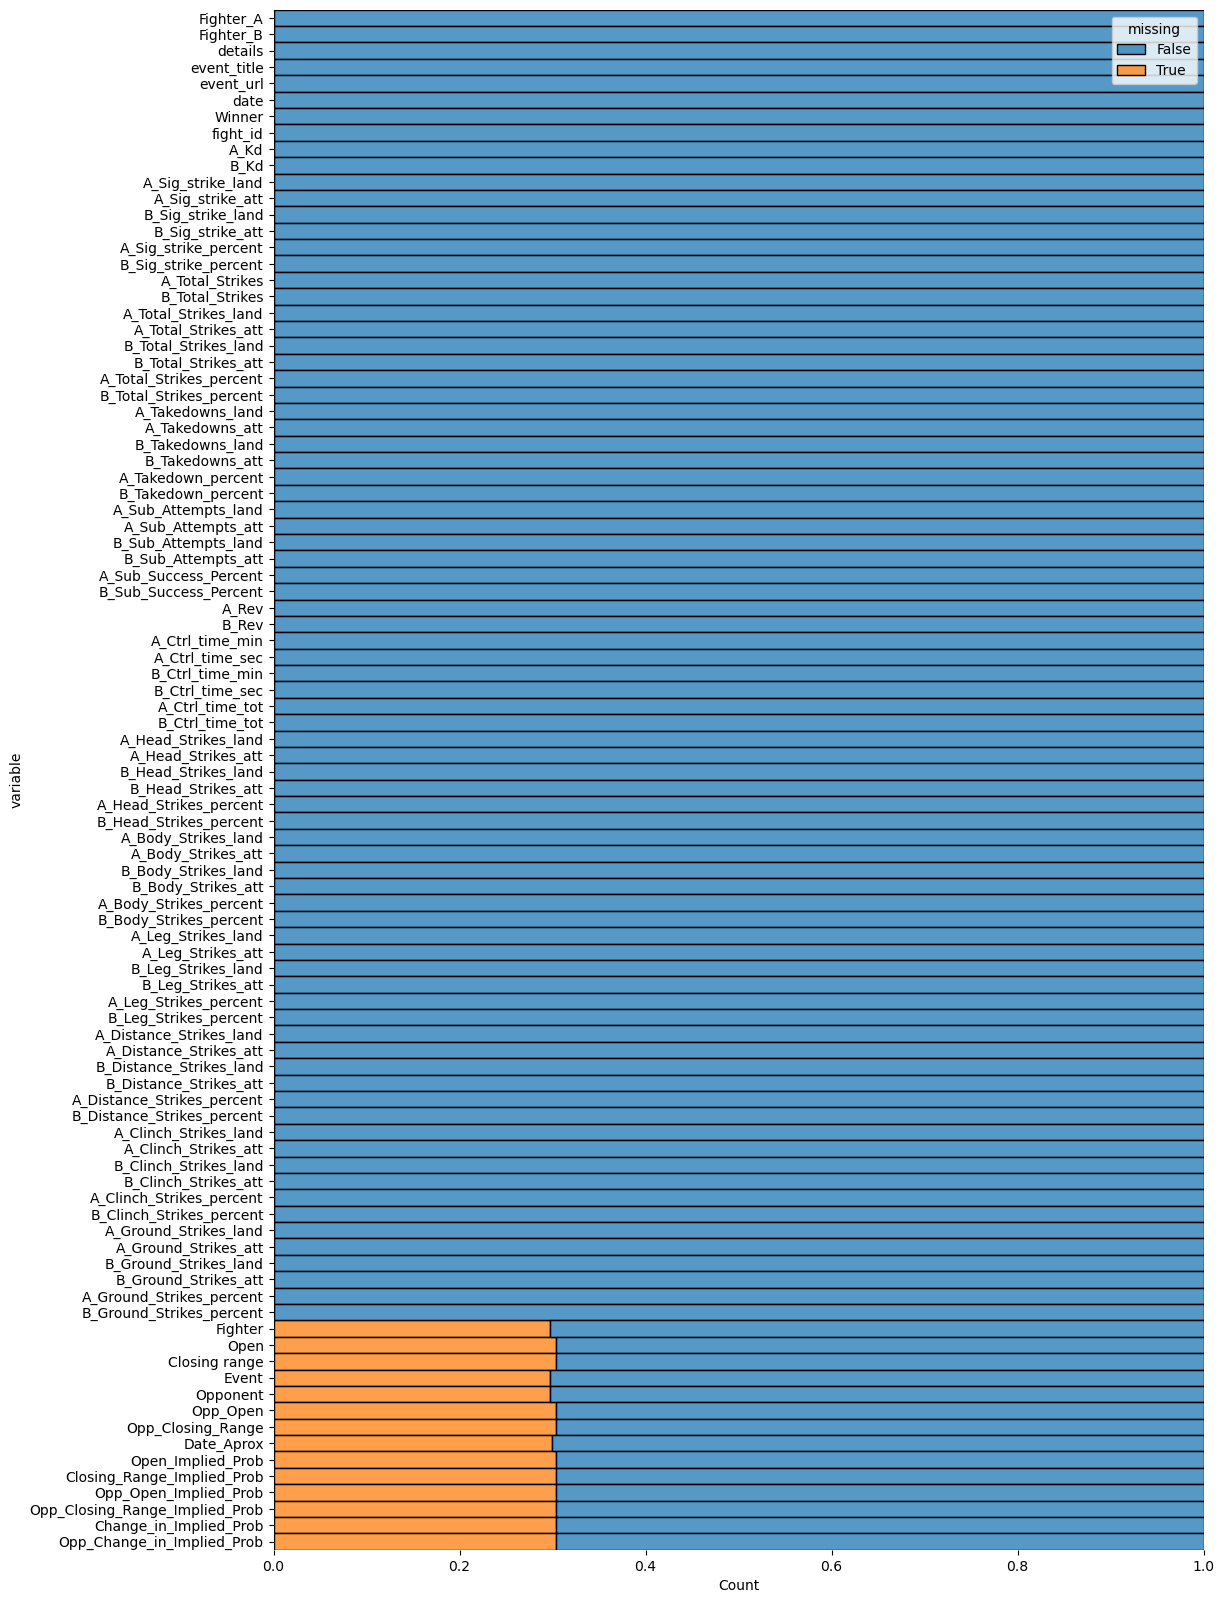

In [40]:
f, ax = plt.subplots(figsize = (12,20))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = double_fights_df.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [41]:
double_fights_df.shape

(15312, 94)

In [42]:
double_fights_df.to_csv('data/final/aggregates/Double_Fights_DF_V1.csv', index=False)

In [43]:
double_fights_df= pd.read_csv('data/final/aggregates/Double_Fights_DF_V1.csv')

In [44]:
double_fights_df.head(3)

,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,fight_id,A_Kd,B_Kd,...,Opponent,Opp_Open,Opp_Closing_Range,Date_Aprox,Open_Implied_Prob,Closing_Range_Implied_Prob,Opp_Open_Implied_Prob,Opp_Closing_Range_Implied_Prob,Change_in_Implied_Prob,Opp_Change_in_Implied_Prob
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,Martin Kampmann,115.0,100.0,2011-11-19,60.78,52.38,46.51,50.00,-8.40,3.49
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,Kyle Bochniak,-185.0,-150.0,2016-08-27,40.82,46.51,64.91,60.00,5.69,-4.91
2,Belal Muhammad,Takashi Sato,Rear Naked Choke,UFC 242: Khabib vs. Poirier,http://www.ufcstats.com/event-details/a79bfbc0...,2019-09-07,"Belal Muhammad ""Remember the Name""",18aff757c54687f1,0,0,...,Takashi Sato,170.0,295.0,2019-09-07,69.70,80.00,37.04,25.32,10.30,-11.72


In [42]:
# find all objects in df
double_fights_df.select_dtypes(include=['object']).columns

Index(['Fighter_A', 'Fighter_B', 'A_Total_Strikes', 'B_Total_Strikes',
       'details', 'event_title', 'event_url', 'date', 'Winner', 'fight_id',
       'event_code'],
      dtype='object')

## Add Feature: In-Fight Statistic Differentials

First make sure that there are no Nans or Infs in the data

In [45]:
#check for nans and infs
double_fights_df.isna().sum()

Fighter_A                            0
Fighter_B                            0
details                              0
event_title                          0
event_url                            0
                                  ... 
Closing_Range_Implied_Prob        4648
Opp_Open_Implied_Prob             4648
Opp_Closing_Range_Implied_Prob    4648
Change_in_Implied_Prob            4648
Opp_Change_in_Implied_Prob        4648
Length: 94, dtype: int64

In [46]:
# turn infs to nans
double_fights_df = double_fights_df.replace([np.inf, -np.inf], np.nan)

In [47]:
# calculate differences between in-match stats

for col in double_fights_df.columns:
    if col.startswith('A_'):
        try:
            new_col = col.replace('A_', 'Dif_')
            double_fights_df[new_col] = double_fights_df[col] - double_fights_df[col.replace('A_', 'B_')]
        except:
            print('error with: ' + col)
    else:
        continue

double_fights_df

error with: A_Total_Strikes


,Fighter_A,Fighter_B,details,event_title,event_url,date,Winner,fight_id,A_Kd,B_Kd,...,Dif_Leg_Strikes_percent,Dif_Distance_Strikes_land,Dif_Distance_Strikes_att,Dif_Distance_Strikes_percent,Dif_Clinch_Strikes_land,Dif_Clinch_Strikes_att,Dif_Clinch_Strikes_percent,Dif_Ground_Strikes_land,Dif_Ground_Strikes_att,Dif_Ground_Strikes_percent
0,Rick Story,Martin Kampmann,Steve English ...,UFC 139: Shogun vs Henderson,http://www.ufcstats.com/event-details/0ec82142...,2011-11-19,"Martin Kampmann ""The Hitman""",89820fae001dd151,0,0,...,0.000000,18,18,0.095791,9,9,0.247500,-4,-4,-1.000000
1,Enrique Barzola,Kyle Bochniak,Dave Hagen ...,UFC on FOX: Maia vs. Condit,http://www.ufcstats.com/event-details/cfbccfed...,2016-08-27,"Kyle Bochniak ""Killer B""",df33799f117000cb,0,0,...,0.130435,9,19,0.023814,5,5,0.200000,0,0,0.000000
2,Belal Muhammad,Takashi Sato,Rear Naked Choke,UFC 242: Khabib vs. Poirier,http://www.ufcstats.com/event-details/a79bfbc0...,2019-09-07,"Belal Muhammad ""Remember the Name""",18aff757c54687f1,0,0,...,0.000000,13,9,0.102729,3,4,0.750000,4,4,1.000000
3,Alex Caceres,Edwin Figueroa,Two Points Deducted: Low Blows by Caceres ...,UFC 143: Diaz vs Condit,http://www.ufcstats.com/event-details/df2cf66d...,2012-02-04,"Edwin Figueroa ""El Feroz""",d019250cc6d93527,0,1,...,0.111111,26,27,0.163489,-3,-3,0.000000,-9,-16,-0.055556
4,TJ Grant,Carlo Prater,Brian Costello ...,UFC on FUEL TV: Korean Zombie vs Poirier,http://www.ufcstats.com/event-details/8caca585...,2012-05-15,TJ Grant,4655930eb83446c7,0,0,...,0.083333,9,16,0.027157,22,25,0.190476,10,11,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15307,Chirico Zak,Alessio Di,Derek Cleary ...,UFC Fight Night: Smith vs. Rakic,http://www.ufcstats.com/event-details/e29cf523...,2020-08-29,Zak Cummings,0a7517a16d2d9db6,1,0,...,0.000000,2,-18,0.057971,-1,0,-1.000000,0,0,0.000000
15308,Hector Aldana,Miguel Baeza,Kick to Leg At Distance,UFC Fight Night: Joanna vs. Waterson,http://www.ufcstats.com/event-details/0941df56...,2019-10-12,"Miguel Baeza ""Caramel Thunder""",1d26ceb1c995655e,0,1,...,-0.250000,-21,-9,-0.378151,0,0,0.000000,-6,-10,-0.600000
15309,Natalia Silva,Andrea Lee,David Ginsberg ...,UFC 292: Sterling vs. O'Malley,http://www.ufcstats.com/event-details/2719f300...,2023-08-19,Natalia Silva,8c7b5b21b3532027,0,0,...,0.235714,27,49,0.058299,0,0,0.000000,0,0,0.000000
15310,Chris Wilson,Jon Fitch,Cecil Peoples ...,UFC 82: Pride of a Champion,http://www.ufcstats.com/event-details/598a58db...,2008-03-01,Jon Fitch,029cd254fe02d4b8,0,0,...,0.130952,-5,-6,-0.056364,5,4,0.500000,-18,-22,-0.818182


In [48]:
# check for infs
double_fights_df.isna().sum()
# only display columns with nans
double_fights_df.isna().sum()[double_fights_df.isna().sum() > 0]

Fighter                           4558
Open                              4648
Closing range                     4648
Event                             4558
Opponent                          4558
Opp_Open                          4648
Opp_Closing_Range                 4648
Date_Aprox                        4580
Open_Implied_Prob                 4648
Closing_Range_Implied_Prob        4648
Opp_Open_Implied_Prob             4648
Opp_Closing_Range_Implied_Prob    4648
Change_in_Implied_Prob            4648
Opp_Change_in_Implied_Prob        4648
dtype: int64

In [56]:
# add difference in odds
# double_fights_df['Dif_Odds'] = double_fights_df['Fighter_A_Odds'] - double_fights_df['Fighter_B_Odds']

#### Add Distribution Stat Features

now fights = double_fights_df, for ease

In [57]:
fights = double_fights_df

In [58]:
def get_fighter_running_dist_stats(fighter, date, col_to_get, stat_to_calc):

    # retrieve data for all fights involving the given fighter
    data = fights[(fights['Fighter_A'] == fighter) | (fights['Fighter_B'] == fighter)]

    # convert date strings to datetime objects
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])

    # filter data to only include fights before the given date
    data = data[data['date'] < datey]

    # create an empty dataframe to store fighter data
    fighter_data = pd.DataFrame()

    # retrieve data for fights where the given fighter is Fighter A
    fighterA_df = fights[fights['Fighter_A'] == fighter]
    # retrieve data for fights where the given fighter is Fighter B
    fighterB_df = fights[fights['Fighter_B'] == fighter]

    # select relevant columns from Fighter A data and rename columns for consistency
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)

    # select relevant columns from Fighter B data and rename columns for consistency
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)

    # append Fighter A and Fighter B data to the fighter_data dataframe
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the chosen statistic based on the input parameter
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  

    # return the chosen statistic
    return x

#### Get Non-specific column names for Feature Creation

In [59]:
# This code creates three lists of column names from a dataframe called 'fights'
# The first list contains column names with 'Dif_' in them
# The second list contains column names that start with 'A_'
# The third list combines the second and first list

dif_cols = [n for n in fights.columns if 'Dif_' in n]
A_cols = [n for n in fights.columns if n.startswith('A_')]
all_metric_cols = A_cols + dif_cols

# This code creates a new dataframe containing the second list of column names without the 'A_' prefix
# It then creates a list of unique column name suffixes

A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())

In [60]:
the_cols

['Kd',
 'Sig_strike_land',
 'Sig_strike_att',
 'Sig_strike_percent',
 'Total_Strikes',
 'Total_Strikes_land',
 'Total_Strikes_att',
 'Total_Strikes_percent',
 'Takedowns_land',
 'Takedowns_att',
 'Takedown_percent',
 'Sub_Attempts_land',
 'Sub_Attempts_att',
 'Sub_Success_Percent',
 'Rev',
 'Ctrl_time_min',
 'Ctrl_time_sec',
 'Ctrl_time_tot',
 'Head_Strikes_land',
 'Head_Strikes_att',
 'Head_Strikes_percent',
 'Body_Strikes_land',
 'Body_Strikes_att',
 'Body_Strikes_percent',
 'Leg_Strikes_land',
 'Leg_Strikes_att',
 'Leg_Strikes_percent',
 'Distance_Strikes_land',
 'Distance_Strikes_att',
 'Distance_Strikes_percent',
 'Clinch_Strikes_land',
 'Clinch_Strikes_att',
 'Clinch_Strikes_percent',
 'Ground_Strikes_land',
 'Ground_Strikes_att',
 'Ground_Strikes_percent']

In [61]:
# test get_fighter_running_dist_stats
get_fighter_running_dist_stats('Khabib Nurmagomedov', '2020-01-18', 'Sig_strike_land', 'mean')

53.15384615384615

These are split because they were causing problems when running all at once

In [63]:
# Mean First

for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'mean'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_1.csv', index=False)

In [ ]:
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'mean'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_2.csv', index=False)

In [ ]:
# Now Std
for col in the_cols:
    fights['A_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'std'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_5.csv', index=False)


In [ ]:
# fighter 2 Std
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'std'), axis=1)

# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2_6.csv', index=False)

New Version:

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2.csv', index=False)

In [ ]:
# Load point for fights df
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V2.csv')

## PART 2 --

This code is building a UFC (Ultimate Fighting Championship) fight dataset with multiple features including fighter statistics, fight metrics, and event information. The ultimate goal is to predict the winner of a fight. 

It broadly does the following:

1. Defines utility functions to generate fighter statistics and aggregate features such as the averages of certain metrics, fighter's data, opponent's data, and statistics differential per fight.
2. Iteratively applies these functions to each row (fight) influencing the DataFrame `fights`.
3. Treats missing data values by imputing missing values or dropping rows where necessary.
4. Extracts additional information about each fight like which round it ended, method of victory, or time to finish.
5. Extracts specific fighter’s biographical data, like height, weight, reach, and age. For missing reach values, it uses median values per height or weight class. 
6. Infers whether the fight was conducted in their typical weight class. 
7. Computes and adds new other derived features, like 'Ape_Index' and 'Leg_Index' that might be helpful indicators or influence the fight outcome.
8. Finally, it creates a 'win?' column to mark if the fighter_A has won the bout, which will be used as a label (target feature) for a machine learning model.

The script makes use of pandas for its data manipulation, and seaborn for visualizing missing data. To reduce calculation time, it saves intermediate data to CSV files at several points and fetches them for later use if needed.

### Feature: Top-Down Averages (typical UFC Style) [THIS WAS STUPID]

In [ ]:
# def get_top_down_averages(fighter, date, col_to_get, dataframe):

#     # for each column in all_metric_cols, calculate the top-down averages, as opposed to bottom-up
#     data = dataframe[(dataframe['Fighter_A'] == fighter) | (dataframe['Fighter_B'] == fighter)]

#     # only get fights before the date
#     datey = pd.to_datetime(date)
#     data['date'] = pd.to_datetime(data['date'])
#     data = data[data['date'] < datey]

#     # fighter could be either fighter A or fighter B
#     fighter_data = pd.DataFrame()


#     # fighterA df
#     fighterA_df = dataframe[dataframe['Fighter_A'] == fighter]
#     fighterB_df = dataframe[dataframe['Fighter_B'] == fighter]
    
#     # keep only the fighters columns date, FighterA, and the col_to_get, 
#     # do same for B, change col names from B to A, and concat
#     fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
#     fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
#     fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
#     fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
#     fighter_data = fighter_data.append(fighterA_df)
#     fighter_data = fighter_data.append(fighterB_df)

#     # append the dataframes on fighter
#     fighter_data = fighter_data.append(fighterA_df)
#     fighter_data = fighter_data.append(fighterB_df)

#     # get the average
#     tot = fighter_data[col_to_get].sum()
#     num = fighter_data[col_to_get].count()
#     x = tot / num
#     return x

In [ ]:
# # delete rolling cols from the_cols
# the_cols = [n for n in the_cols if 'Rolling' not in n]
# the_cols

In [ ]:


# for col in the_cols:
#     fights['A_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_A'], row['date'], col, fights), axis=1)

In [ ]:
# for col in the_cols:
#     fights['B_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_B'], row['date'], col, fights), axis=1)

In [ ]:
# fights.to_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

In [ ]:
# fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

### Add Opponent Stats

In [ ]:
def get_opponent_averages(datafrm, date, col_to_get, fighter):
    col_to_get = 'B_' + col_to_get
    data = datafrm[(datafrm['Fighter_A'] == fighter) | (datafrm['Fighter_B'] == fighter)]
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    fighter_data = pd.DataFrame()

    fighterA_df = datafrm[datafrm['Fighter_A'] == fighter]
    fighterB_df = datafrm[datafrm['Fighter_B'] == fighter]

    # switch A_ and B_ to B_ and A_ in fighterB_df
    fighterB_df.columns = [n.replace('A_', 'C_') if n.startswith('A_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('B_', 'D_') if n.startswith('B_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('C_', 'B_') if n.startswith('C_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('D_', 'A_') if n.startswith('D_') else n for n in fighterB_df.columns]

    # copy fighter_A and fighter_B columns to new dataframe, then switch fighter_A and fighter_B columns

    fighterB_df.rename(columns={'Fighter_A': 'Fighter_A2', 'Fighter_B': 'Fighter_B2'}, inplace=True)
    fighterB_df.rename(columns={'Fighter_B2': 'Fighter_A', 'Fighter_A2': 'Fighter_B'}, inplace=True)

    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get sum of col to get
    col_sum = fighter_data[col_to_get].sum()
    # get number of fights
    num_fights = len(fighter_data)
    # get average
    avg = col_sum / num_fights

    return avg


In [ ]:
# test
get_opponent_averages(fights, '2017-01-01', 'Sig_strike_land', 'Conor McGregor')

In [ ]:
cols = [n for n in fights.columns if n.startswith('B_')]
cols = [n for n in cols if 'topdown_' not in n]
cols = [n for n in cols if 'Rolling_' not in n]
cols = [n for n in cols if 'Dif_' not in n]

In [ ]:
# delete the first 2 characters of each in col
cols2 = pd.DataFrame(cols)
cols2['nonspecific'] = cols2[0].str[2:]
cols2

# get unique values
the_cols = list(cols2['nonspecific'].unique())

# drop percent cols from the_cols
the_cols = [n for n in the_cols if 'percent' not in n]
the_cols = [n for n in the_cols if 'Percent' not in n]
the_cols

Get Opponent Averages (2 min per feature)

In [ ]:
n=0

# loop through the remaining columns
for col in the_cols:
    try:
        fights['A_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_A']), axis=1)
        fights['B_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_B']), axis=1)
        # save to csv
        fights.to_csv('data/intermediate_data/Opponent_Averages_{}_.csv'.format(col))

        n = n+1
        print(f' {col}, #{n} / {len(the_cols)} done.')
    except:
        print(f'Error on {col}')
        # play_danger()

# play_jobs_done()

In [ ]:
# load all data in data/intermediate_data, adding columns to fights
for file in os.listdir('data/intermediate_data/'):
    if file.startswith('Opponent_Averages_'):
        print(file)
        df = pd.read_csv('data/intermediate_data/' + file)
        fights_cols = list(fights.columns)
        df_cols = list(df.columns)
        cols_to_add = [n for n in df_cols if n not in fights_cols]
        for col in cols_to_add:
            fights[col] = df[col]
        
fights

In [ ]:
# Calculate the percent columns
fights['A_Opp_Avg_Sig_Strike_Accuracy'] = fights['A_Opp_Avg_Sig_strike_land'] / fights['A_Opp_Avg_Sig_strike_att']
fights['B_Opp_Avg_Sig_Strike_Accuracy'] = fights['B_Opp_Avg_Sig_strike_land'] / fights['B_Opp_Avg_Sig_strike_att']
fights['A_Opp_Avg_Total_Strike_Accuracy'] = fights['A_Opp_Avg_Total_Strikes_land'] / fights['A_Opp_Avg_Total_Strikes_att']
fights['B_Opp_Avg_Total_Strike_Accuracy'] = fights['B_Opp_Avg_Total_Strikes_land'] / fights['B_Opp_Avg_Total_Strikes_att']
fights['A_Opp_Avg_Takedown_Accuracy'] = fights['A_Opp_Avg_Takedowns_land'] / fights['A_Opp_Avg_Takedowns_att']
fights['B_Opp_Avg_Takedown_Accuracy'] = fights['B_Opp_Avg_Takedowns_land'] / fights['B_Opp_Avg_Takedowns_att']
fights['A_Opp_Avg_Submission_Accuracy'] = fights['A_Opp_Avg_Sub_Attempts_land'] / fights['A_Opp_Avg_Sub_Attempts_att']
fights['B_Opp_Avg_Submission_Accuracy'] = fights['B_Opp_Avg_Sub_Attempts_land'] / fights['B_Opp_Avg_Sub_Attempts_att']
# head strike accuracy
fights['A_Opp_Avg_Head_Strike_Accuracy'] = fights['A_Opp_Avg_Head_Strikes_land'] / fights['A_Opp_Avg_Head_Strikes_att']
fights['B_Opp_Avg_Head_Strike_Accuracy'] = fights['B_Opp_Avg_Head_Strikes_land'] / fights['B_Opp_Avg_Head_Strikes_att']
# body strike accuracy
fights['A_Opp_Avg_Body_Strike_Accuracy'] = fights['A_Opp_Avg_Body_Strikes_land'] / fights['A_Opp_Avg_Body_Strikes_att']
fights['B_Opp_Avg_Body_Strike_Accuracy'] = fights['B_Opp_Avg_Body_Strikes_land'] / fights['B_Opp_Avg_Body_Strikes_att']
# leg strike accuracy
fights['A_Opp_Avg_Leg_Strike_Accuracy'] = fights['A_Opp_Avg_Leg_Strikes_land'] / fights['A_Opp_Avg_Leg_Strikes_att']
fights['B_Opp_Avg_Leg_Strike_Accuracy'] = fights['B_Opp_Avg_Leg_Strikes_land'] / fights['B_Opp_Avg_Leg_Strikes_att']
# distance strike accuracy
fights['A_Opp_Avg_Distance_Strike_Accuracy'] = fights['A_Opp_Avg_Distance_Strikes_land'] / fights['A_Opp_Avg_Distance_Strikes_att']
fights['B_Opp_Avg_Distance_Strike_Accuracy'] = fights['B_Opp_Avg_Distance_Strikes_land'] / fights['B_Opp_Avg_Distance_Strikes_att']
# clinch strike accuracy
fights['A_Opp_Avg_Clinch_Strike_Accuracy'] = fights['A_Opp_Avg_Clinch_Strikes_land'] / fights['A_Opp_Avg_Clinch_Strikes_att']
fights['B_Opp_Avg_Clinch_Strike_Accuracy'] = fights['B_Opp_Avg_Clinch_Strikes_land'] / fights['B_Opp_Avg_Clinch_Strikes_att']
# ground strike accuracy
fights['A_Opp_Avg_Ground_Strike_Accuracy'] = fights['A_Opp_Avg_Ground_Strikes_land'] / fights['A_Opp_Avg_Ground_Strikes_att']
fights['B_Opp_Avg_Ground_Strike_Accuracy'] = fights['B_Opp_Avg_Ground_Strikes_land'] / fights['B_Opp_Avg_Ground_Strikes_att']




In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [ ]:
# check for nans and show them
fights.isna().sum()

In [ ]:
# check for infs and show them
fights[fights == np.inf].sum()

In [ ]:
# show all columns with infs
[fights[col].isna().sum() for col in fights.columns if fights[col].isna().sum() > 0]

In [ ]:
# check current columns
fights.columns.to_list()

### Feature: Rolling Career Stat Differentials

#### 1) Mean (Average)

In [ ]:
# get columns with Rolling and Mean
rolling_mean_cols= [n for n in fights.columns if 'Rolling' in n and 'mean' in n]
rolling_mean_cols = pd.DataFrame(rolling_mean_cols)
rolling_mean_cols['nonspecific'] = rolling_mean_cols[0].str[2:]
rmc = rolling_mean_cols['nonspecific'].unique()

In [ ]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

#### 2) Median (Average) (No Longer In Use)

In [ ]:
# rolling_median_cols= [n for n in fights.columns if 'Rolling' in n and 'median' in n]
# rolling_median_cols = pd.DataFrame(rolling_median_cols)
# rolling_median_cols['nonspecific'] = rolling_median_cols[0].str[2:]
# rmc = rolling_median_cols['nonspecific'].unique()

In [ ]:
# for col in rmc:
#     fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

# fights.head()

#### 3) Standard Deviations 

In [ ]:
rolling_std_cols= [n for n in fights.columns if 'Rolling' in n and 'std' in n]
rolling_std_cols = pd.DataFrame(rolling_std_cols)
rolling_std_cols['nonspecific'] = rolling_std_cols[0].str[2:]
rsc = rolling_std_cols['nonspecific'].unique()
rsc

In [ ]:
for col in rsc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

In [ ]:
# check for nans, show only if there are any
fights.isna().sum()[fights.isna().sum() > 0]

In [ ]:
# check for infs, show only if there are any
fights[fights == np.inf].sum()[fights[fights == np.inf].sum() > 0]

In [ ]:
# Save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V5.csv')

In [ ]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]

if len(nothere) > 0:
    cols = nothere.index

    f, ax = plt.subplots(figsize = (12,12))

    sns.despine(f, left=True, bottom=True)
    sns.histplot(
        data = fights[cols].isna().melt(value_name='missing'),
        y= 'variable',
        hue = 'missing',
        multiple = 'fill', ax = ax)

    ax.set_title('Missing Data by Column', fontsize = 20)
    ax.set_xlabel('Count', fontsize = 16)
    ax.set_ylabel('Column', fontsize = 16)
    ax.tick_params(labelsize = 14)

    plt.show()

else:
    print('No missing values')

### Feature: UFC.Com Bio Data

In [ ]:
fighter_bios = pd.read_csv('data/final/aggregates/All_Fighter_Bios.csv')
fighter_bios.head(1)

In [ ]:
# drop unnamed column
fighter_bios.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [ ]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fighter_bios.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

In [ ]:
# What about only Active fighter Nans?
active = fighter_bios.loc[fighter_bios['Status'] == "Active"]
active

In [ ]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = active.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

#### Dealing with Initial Missing Values

Initial missing values are those such as Age, Status, Fighting Style (categorical variables) which I can impute unknown categories to without much issue. The others (height, weight, reach, etc) must be dealt with after the merge.

In [ ]:
# if missing place of birth, replace with 'Unknown'
fighter_bios['Place of Birth'].fillna('Unknown', inplace=True)

# if missing fighting style, replace with 'Unknown'
fighter_bios['Fighting style'].fillna('Unknown', inplace=True)

# if missing Trains at, replace with 'Unknown'
fighter_bios['Trains at'].fillna('Unknown', inplace=True)

# if missing status, replace with 'Unknown'
fighter_bios['Status'].fillna('Unknown', inplace=True)

# if missing age, replace with median
fighter_bios['Age'].fillna(fighter_bios['Age'].median(), inplace=True)

# if missing height, replace with median -- thankfully not many missing, as 
# this is a somewhat important feature
fighter_bios['Height'].fillna(fighter_bios['Height'].median(), inplace=True)

# if missing weight, replace with median -- thankfully not many missing
fighter_bios['Weight'].fillna(fighter_bios['Weight'].median(), inplace=True)

In [ ]:
def get_bio_data(fighter, stat):
    try:
        data = fighter_bios[fighter_bios['fighter'] == fighter]
        d = data[stat].values[0]
        d = pd.to_numeric(d)
        return d
    except:
        return nan

In [ ]:
# test
weight = get_bio_data('Khabib Nurmagomedov', 'Height')
weight

In [ ]:
fights['A_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Height'), axis=1)
fights['B_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Height'), axis=1)
fights['Dif_Height'] = fights['A_Height'] - fights['B_Height']

In [ ]:
fights['A_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Reach'), axis=1)
fights['B_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Reach'), axis=1)
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
fights['A_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Leg reach'), axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Leg reach'), axis=1)
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']

In [ ]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [ ]:
# drop rows missing height data
fights.dropna(subset=['A_Height', 'B_Height'], inplace=True)
len(fights)

In [ ]:
# New column indicating if we have the reach data for fighter A
fights['A_Reach_NA'] = fights['A_Reach'].isna()

# New column indicating if we have the reach data for fighter B
fights['B_Reach_NA'] = fights['B_Reach'].isna()

# New column indicating if we have the reach data for either fighter
fights['Reach_NA'] = fights['A_Reach_NA'] | fights['B_Reach_NA']

# New column indicating if we have leg reach data for fighter A
fights['A_Leg_Reach_NA'] = fights['A_Leg_Reach'].isna()

# New column indicating if we have leg reach data for fighter B
fights['B_Leg_Reach_NA'] = fights['B_Leg_Reach'].isna()

# New column indicating if we have leg reach data for either fighter
fights['Leg_Reach_NA'] = fights['A_Leg_Reach_NA'] | fights['B_Leg_Reach_NA']

### Add Weightclass

Then you can break down height, reach, etc... by weightclass, which is in the All_Events_Fights_and_FightUrls file

In [ ]:
all_events = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [ ]:
def find_typical_weightclass(fighter):
    try:
        data = all_events[all_events['Fighter1'] == fighter]
        data2 = all_events[all_events['Fighter2'] == fighter]
        data = pd.concat([data, data2])
        d = data['Weight class'].value_counts().index[0]
        return d
    except:
        return nan


In [ ]:
# test
weight = find_typical_weightclass('Khabib Nurmagomedov')
weight

In [ ]:
fights['A_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_A']), axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_B']), axis=1)

In [ ]:
fights.head(3)

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V6.csv', index=False)

In [ ]:
# use fight_id to find weightclass of fight
def find_weightclass(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Weight class'].values[0]
        return d
    except:
        return nan

In [ ]:
# test
weight = find_weightclass('ff6c8dab41efcc09')
weight

In [ ]:
fights['fight_weightclass'] = fights.apply(lambda row: find_weightclass(row['fight_id']), axis=1)

In [ ]:
fights.head(3)

In [ ]:
fights['A_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['A_Typical_Weightclass'] == row['fight_weightclass'], axis=1)
fights['B_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['B_Typical_Weightclass'] == row['fight_weightclass'], axis=1)

In [ ]:
fights.head(3)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V7.csv', index=False)

### Feature: Method

The main methods of fight finishing are:
- Decision (DEC)
- KO/TKO
- Submission (SUB)


In [ ]:
all_events.head(2)

In [ ]:
# split Method into Method and Method Detail
all_events['Method_Primary'] = all_events['Method'].str.split('  ', expand=True)[0]
all_events['Method_Detail'] = all_events['Method'].str.split('  ', expand=True)[1]
all_events.head(3)

In [ ]:
def get_method(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Primary'].values[0]
        return d
    except:
        return nan

In [ ]:
def get_details(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Detail'].values[0]
        return d
    except:
        return nan

In [ ]:
# test
method = get_method('ff6c8dab41efcc09')
method

In [ ]:
fights['InFightData__Method_Primary'] = fights.apply(lambda row: get_method(row['fight_id']), axis=1)
fights['InFightData__Method_Detail'] = fights.apply(lambda row: get_details(row['fight_id']), axis=1)

### Feature: Round & Time

In [ ]:
def get_round_time(fight_id, round_or_time):
    try: 
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        if round_or_time == 'round':
            d = data['Round'].values[0]
        elif round_or_time == 'time':
            d = data['Time'].values[0]
        return d
    except:
        return nan

In [ ]:
# test
round = get_round_time('ff6c8dab41efcc09', 'round')
round

In [ ]:
fights['InFightData__Round'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'round'), axis=1)
fights['InFightData__Time'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'time'), axis=1)

In [ ]:
fights.head(3)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V8.csv', index=False)

### Dealing with Remaining Missing Values

In [ ]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

In [ ]:
# replace nan values in "InFightData__Method_Detail" with "None"
fights['InFightData__Method_Detail'] = fights['InFightData__Method_Detail'].fillna('None')

In [ ]:
# replace nan values in Typical Weightclass with current weightclass
fights['A_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['A_Typical_Weightclass']) else row['A_Typical_Weightclass'], axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['B_Typical_Weightclass']) else row['B_Typical_Weightclass'], axis=1)

In [ ]:
# get median reach per height
reach_by_height = fights.groupby('A_Height')['A_Reach'].median()
reach_by_height

In [ ]:
# replace nan values in reach with median reach per height
fights['A_Reach'] = fights.apply(lambda row: reach_by_height[row['A_Height']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_height[row['B_Height']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

In [ ]:
# get median leg reach per height
leg_reach_by_height = fights.groupby('A_Height')['A_Leg_Reach'].median()
leg_reach_by_height

In [ ]:
# replace nan values in leg reach with median leg reach per height
fights['A_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['A_Height']] if pd.isnull(row['A_Leg_Reach']) else row['A_Leg_Reach'], axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['B_Height']] if pd.isnull(row['B_Leg_Reach']) else row['B_Leg_Reach'], axis=1)

In [ ]:
# recalculate leg reach dif and reach dif
fights['A_Leg_Reach_Dif'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['A_Reach_Dif'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
fights.dtypes[-40:]

In [ ]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

In [ ]:
# get median reach per weightclass
reach_by_weightclass = fights.groupby('fight_weightclass')['A_Reach'].median()
reach_by_weightclass

In [ ]:
# get median height per weightclass
height_by_weightclass = fights.groupby('fight_weightclass')['A_Height'].median()
height_by_weightclass

In [ ]:
# replace nan values in "A_Reach" with median for weight class
fights['A_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

# replace nan values in "A_Height" with median for weight class
fights['A_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Height']) else row['A_Height'], axis=1)
fights['B_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Height']) else row['B_Height'], axis=1)


In [ ]:
# Once again, re-run the Difs
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
# get missing
missing_values = fights.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(fights) * 100
missing_values

In [ ]:
# drop nan values
fights = fights.dropna()


In [ ]:
# drop A_Reach_Dif and A_Leg_Reach_Dif
fights = fights.drop(['A_Reach_Dif', 'A_Leg_Reach_Dif'], axis=1)

### Feature: Size Ratios

In [ ]:
fights['A_Ape_Index'] = fights['A_Reach'] / fights['A_Height']
fights['B_Ape_Index'] = fights['B_Reach'] / fights['B_Height']

# Leg_Index = Leg_Reach / Height
fights['A_Leg_Index'] = fights['A_Leg_Reach'] / fights['A_Height']
fights['B_Leg_Index'] = fights['B_Leg_Reach'] / fights['B_Height']

# Leg_to_Wing_Index = Leg_Reach / Reach
fights['A_Leg_to_Wing_Index'] = fights['A_Leg_Reach'] / fights['A_Reach']
fights['B_Leg_to_Wing_Index'] = fights['B_Leg_Reach'] / fights['B_Reach']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V9.csv', index=False)

### Feature: Winner

In [ ]:
# split Winner columns by " 
fights['Winner'] = fights['Winner'].str.split('"').str[0].str.strip()
fights.head(2)

In [ ]:
# add column "win?", if column winner is equal to fighter_A
fights['win?'] = fights.apply(lambda row: 1 if row['Winner'] == row['Fighter_A'] else 0, axis=1)
fights.head(30)

In [ ]:
# check number of wins vs losses
fights['win?'].value_counts()

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V10.csv', index=False)

## Part 3

### Feature: Favorite

This code is for a Python script that processes a dataset of fights and calculates various statistics about them. The script performs the following steps:

1. Extracts columns that contain odds and dates.
2. Creates new variables that mark whether a fighter is favored or not based on odds and calculates the number of fights and wins a specific fighter has before a certain date.
3. Defines functions to calculate the number of UFC fights, number of UFC wins, and number of UFC losses a specific fighter has before a certain date.
4. Calculates winning percentages and the differences in statistics between two fighters.
5. Extracts last 3 and 5 fights' win percentage for each fighter and calculates winning and losing percentages by knockout (KO) and decision.
6. To analyze the round and time statistics, it converts the time to seconds and creates per-round averages for both fighters.
7. Takes into account Training history of fighters and main fighting style.
8. Finally, it saves the processed data to a csv file.

Each fighter in each fight is designated as either Fighter_A or Fighter_B, and all calculated attributes are given to each fighter (e.g., 'A_Total_UFC_Fights', 'B_Total_UFC_Fights'). Increases and decreases are determined by these statistics ('Dif_Total_UFC_Fights'). 

It is also working with a dataset (CSV file) that seems to contain a variety of information about fighting matches, such as specific fighters involved, dates, and a wide range of stats. It applies different calculations for extract features from this data and save calculated results to new csv files. 


In [ ]:
# get columns in fight df with odds in the name
odds_columns = [col for col in fights.columns if 'Odds' in col]
odds_columns

In [ ]:
fights['favorite?'] = np.where(fights['Fighter_A_Odds'] < fights['Fighter_B_Odds'], 1, 0)
fights['favorite?'].value_counts()

In [ ]:
fight_check_cols = ['Fighter_A', 'Fighter_B', 'Winner', 'win?', 'Fighter_A_Odds', 'Fighter_B_Odds','favorite?']
fights[fight_check_cols].head(30)

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V11.csv', index=False)

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V11.csv')

In [ ]:
fights.head()

### Features: Win/Loss Details

In [ ]:
# get columns with date in the name
date_columns = [col for col in fights.columns if 'date' in col]
date_columns

In [ ]:
# add a formatted date column
fights['datetime'] = pd.to_datetime(fights['date'])
fights['date_formatted'] = fights['datetime'].dt.date

In [ ]:
fights

In [ ]:
def get_number_UFC_fights(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data)


In [ ]:
get_number_UFC_fights('Conor McGregor', '2020-01-01')

In [ ]:
fights['A_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Total_UFC_Fights'] = fights['A_Total_UFC_Fights'] - fights['B_Total_UFC_Fights']

In [ ]:
fights.head(3)

#### Wins

In [ ]:
# add number of wins
def get_number_UFC_wins(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['win?'].sum()

In [ ]:
fights['A_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_UFC_Wins'] = fights['A_UFC_Wins'] - fights['B_UFC_Wins']

#### Losses

In [ ]:
def get_number_UFC_losses(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data) - data['win?'].sum()

In [ ]:
fights['A_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_B'], row['datetime']), axis=1)


# add diff
fights['Dif_UFC_Losses'] = fights['A_UFC_Losses'] - fights['B_UFC_Losses']

#### W/L Percentages

In [ ]:
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Wins'] / fights['A_Total_UFC_Fights']
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Wins'] / fights['B_Total_UFC_Fights']

# nans to 0
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'].fillna(0)
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Win_Percentage'].fillna(0)


# add diff
fights['Dif_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'] - fights['B_UFC_Win_Percentage']

### Last 5

#### Last 5 Win Percentage

In [ ]:
def get_last5_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(5)
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'].fillna(0)
fights['B_Last5_Win_Percentage'] = fights['B_Last5_Win_Percentage'].fillna(0)

# add diff
fights['Dif_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'] - fights['B_Last5_Win_Percentage']

#### Last 3 Win Percentage

In [ ]:
def get_last3_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(3)
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'].fillna(0)
fights['B_Last3_Win_Percentage'] = fights['B_Last3_Win_Percentage'].fillna(0)

# add diff
fights['Dif_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'] - fights['B_Last3_Win_Percentage']

### Win_by / Loss_by Features

In [ ]:

fights['InFightData__Method_Primary'].value_counts()

In [ ]:
def get_general_method(fight_method):
    if 'DEC' in fight_method:
        return 'DEC'
    elif 'SUB' in fight_method:
        return 'SUB'
    elif 'KO' in fight_method:
        return 'KO'
    else:
        return 'OTHER'

In [ ]:
# make general method column
fights['InFightData__General_Method'] = fights['InFightData__Method_Primary'].apply(lambda x: get_general_method(x))

In [ ]:
fights.head(2)

In [ ]:
def get_win_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

def get_loss_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# make nans 0
fights['A_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'].fillna(0)
fights['B_Win_By_KO_Percentage'] = fights['B_Win_By_KO_Percentage'].fillna(0)

# add diff
fights['Dif_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'] - fights['B_Win_By_KO_Percentage']

In [ ]:
fights['A_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'].fillna(0)
fights['B_Loss_By_KO_Percentage'] = fights['B_Loss_By_KO_Percentage'].fillna(0)

# add diff
fights['Dif_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'] - fights['B_Loss_By_KO_Percentage']

#### Win/Loss by DEC

In [ ]:
def get_win_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

def get_loss_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# make nans 0
fights['A_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'].fillna(0)
fights['B_Win_By_Decision_Percentage'] = fights['B_Win_By_Decision_Percentage'].fillna(0)

# add diff
fights['Dif_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'] - fights['B_Win_By_Decision_Percentage']

In [ ]:
fights['A_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# nans to 0
fights['A_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'].fillna(0)
fights['B_Loss_By_Decision_Percentage'] = fights['B_Loss_By_Decision_Percentage'].fillna(0)

# add diff
fights['Dif_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'] - fights['B_Loss_By_Decision_Percentage']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V12.csv', index=False)

### Round & Time Statistics

In [ ]:
# find round columns
round_cols = [col for col in fights.columns if 'Round' in col]
round_cols

In [ ]:
time_cols = [col for col in fights.columns if 'Time' in col]
time_cols

In [ ]:
fights.InFightData__Round.dtypes

In [ ]:
fights.InFightData__Time

In [ ]:
# convert time to seconds
fights['final_round_seconds'] = fights.InFightData__Time.apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [ ]:
fights['InFightData__Total_Fight_Time_Seconds'] = (fights['InFightData__Round'] - 1) * 5 * 60 + fights['final_round_seconds']

#### Career Fight Time

In [ ]:
def get_career_fight_time_seconds(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['InFightData__Total_Fight_Time_Seconds'].sum()

In [ ]:
fights['A_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_B'], row['datetime']), axis=1)


# add diff
fights['Dif_UFC_Fight_Time_Seconds'] = fights['A_UFC_Fight_Time_Seconds'] - fights['B_UFC_Fight_Time_Seconds']

### Fix NANs

In [ ]:
missing = fights.isna().sum()
missing[missing > 0]
missing = missing[missing > 0]
missing

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V13.csv', index=False)

### Stats / Round Features

For these, use 1) Top down, and 2) Opponent averages

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V13.csv')

In [ ]:
topdown_cols = [n for n in fights.columns.to_list() if 'topdown' in n]
# A TOPDOWN
a_topdown_cols = [n for n in topdown_cols if n.startswith('A_')]
# get rid of any percent columns
a_topdown_cols = [n for n in a_topdown_cols if 'percent' not in n]

# B TOPDOWN
b_topdown_cols = [n for n in topdown_cols if n.startswith('B_')]
# get rid of any percent columns
b_topdown_cols = [n for n in b_topdown_cols if 'percent' not in n]


In [ ]:
# drop topdown cols, we dont need them, they were a mistake. 
fights = fights.drop(topdown_cols, axis=1)

In [ ]:
# list all cols
fights.columns.to_list()

In [ ]:
rolling_cols = [n for n in fights.columns.to_list() if 'Rolling' in n]

a_rolling_cols = [n for n in rolling_cols if n.startswith('A_')]
b_rolling_cols = [n for n in rolling_cols if n.startswith('B_')]

In [ ]:
fights.head(2)

In [ ]:
# use A_UFC_Fight_Time_Seconds to deduce total number of rounds
# 5 minutes per round
# get total number of rounds in ufc
fights['A_UFC_Fight_Rounds'] = fights['A_UFC_Fight_Time_Seconds'] / 300
fights['B_UFC_Fight_Rounds'] = fights['B_UFC_Fight_Time_Seconds'] / 300

In [ ]:
# add per-round averages using avg columns
for col in a_rolling_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_rolling_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']

In [ ]:
fights.head(2)

In [ ]:
fights.columns.to_list()

In [ ]:
# get opponent average columns
opp_avg_cols = [n for n in fights.columns.to_list() if 'Opp_Avg' in n]
# A OPP AVG
a_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('A_')]
# get rid of any percent columns
a_opp_avg_cols = [n for n in a_opp_avg_cols if 'percent' not in n]

# B OPP AVG
b_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('B_')]
# get rid of any percent columns
b_opp_avg_cols = [n for n in b_opp_avg_cols if 'percent' not in n]

b_opp_avg_cols

In [ ]:
# add per-round averages using opponent averages
for col in a_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']


#### Add Per-Round Difs

In [ ]:
# get rolling per_round columns
rolling_per_round_cols = [n for n in fights.columns.to_list() if 'Rolling' in n and 'per_round' in n]
# strip the A_ or B_ from the front
rolling_per_round_cols = [n[2:] for n in rolling_per_round_cols]
# get unique
rolling_per_round_cols = list(set(rolling_per_round_cols))
rolling_per_round_cols

In [ ]:
for col in rolling_per_round_cols:
    fights[f'Dif_{col}'] = fights[f'A_{col}'] - fights[f'B_{col}']

In [ ]:
# get opp_avg per_round columns
opp_avg_per_round_cols = [n for n in fights.columns.to_list() if 'Opp_Avg' in n and 'per_round' in n]

opp_avg_per_round_cols = [n[2:] for n in opp_avg_per_round_cols]
opp_avg_per_round_cols = list(set(opp_avg_per_round_cols))


for col in opp_avg_per_round_cols:
    fights[f'Dif_{col}'] = fights[f'A_{col}'] - fights[f'B_{col}']

In [ ]:
fights.head(2)

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V14.csv', index=False)

In [ ]:
fights.columns.to_list()

4/5/23 -- Adding Fighter Training History

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V14.csv')

In [ ]:
all_fighter_training_history = pd.read_csv('data/final/aggregates/All_Fighter_Training_History_Fixed_V2.csv')
all_fighter_training_history.head(2)

In [ ]:
# rename Martial_Arts_1 to MA_1
all_fighter_training_history = all_fighter_training_history.rename(columns={'Martial_Arts_1': 'MA_1'})

In [ ]:
# strip all values
all_fighter_training_history = all_fighter_training_history.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:

# Function to shift martial arts columns when Martial_Arts_1 is NaN
def shift_martial_arts_columns(row):
    ma_columns = [f'MA_{i}' for i in range(1, 17)]  # Adjust the range according to the number of martial arts columns
    ma_values = row[ma_columns]
    instructor_columns = [f'Instructor_{i}' for i in range(1, 17)]  # Adjust the range according to the number of instructor columns
    instructor_values = row[instructor_columns]
    year_started_columns = [f'Year_Started_{i}' for i in range(1, 17)]  # Adjust the range according to the number of year started columns
    year_started_values = row[year_started_columns]


    # Shift the values if Martial_Arts_1 is NaN
    if pd.isna(row['MA_1']):
        ma_values = ma_values.shift(-1)
        instructor_values = instructor_values.shift(-1)
        year_started_values = year_started_values.shift(-1)

    row[ma_columns] = ma_values
    row[instructor_columns] = instructor_values
    row[year_started_columns] = year_started_values
    return row

# Apply the function to the dataframe
df = all_fighter_training_history.apply(shift_martial_arts_columns, axis=1)
print(df)

In [ ]:
def get_martial_art_history(fighter, ma_number, ret='martial_art'):
    try:
        data = df[df['Fighter_Name'] == fighter]
        
        # Get martial art, instructor, and year started for the specified martial art number
        ma = data[f'MA_{ma_number}'].values[0]
        instructor = data[f'Instructor_{ma_number}'].values[0]
        year_started = data[f'Year_Started_{ma_number}'].values[0]
        
        if ret == 'martial_art':
            return ma
        elif ret == 'instructor':
            return instructor
        elif ret == 'year_started':
            return year_started
        elif ret == 'all':
            return ma, instructor, year_started
        else: 
            return None
    except:
        print(f"Error with {str(fighter)} and {str(ma_number)})")
        return np.nan, np.nan, np.nan

In [ ]:
get_martial_art_history('Amanda Nunes', 1, 'martial_art')


In [ ]:
# add initial martial art to each fighter
fights['A_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'martial_art'), axis=1)
fights['B_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'martial_art'), axis=1)
fights['B_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'martial_art'), axis=1)
fights['B_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'year_started'), axis=1)


In [ ]:
fights

In [ ]:
# make sure 'Year_Started' is an integer, if it cant be converted to an integer, set it to NaN
fights['A_Martial_Art_Year_Started_1'] = fights['A_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_1'] = fights['B_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_2'] = fights['A_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_2'] = fights['B_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_3'] = fights['A_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_3'] = fights['B_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)


In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V15.csv', index=False)
fights.to_csv('data/final/aggregates/Double_Fights_DF_V16.csv', index=False)


## Add Tapology Data

This includes:
- UFC Win-by %s (KO, SUB, DEC)
- UFC Lose-by %s ('')
- Previous Organizations
- Previous Record
- Previous Win-by %s
- Previous Lose-by %s


Data Stored: data/tapology/fighters

In [ ]:
# Load fights 15
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V15.csv')

In [ ]:
fights.head()

In [ ]:
# selenium imports
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait


In [ ]:
def get_fighter_tapology(url):
    # scrape with requests, using a header
    header = {
                        "User-Agent": "Mozilla/6.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
                        "X-Requested-With": "XMLHttpRequest"
        }

    # scrape with requests
    r = requests.get(url, headers = header)
    soup = BeautifulSoup(r.text, 'html.parser')

    fighter_name = soup.find('div', {'class': 'fighterUpcomingHeader'})

    values = fighter_name.text
    values = values.split('\n')
    # delete empty strings
    values = list(filter(None, values))
    # only keep last item
    values = values[-1]
    fighter_name = values

    # get Fighter Details
    fighter_details = soup.find_all('div', {'class': 'details details_two_columns'})
    fighter_details_text = fighter_details[0].text
    # split on \n
    fighter_details_text = fighter_details_text.split('\n')
    # remove empty strings
    fighter_details_text = list(filter(None, fighter_details_text))
    # replace | with new line
    fighter_details_text = [x.replace('|', '\n') for x in fighter_details_text]
    # replace any '\n ' with ''
    fighter_details_text = [x.replace('\n ', '') for x in fighter_details_text]

    # Creating a dictionary from the list
    fighter_dict = {}
    for i in range(len(fighter_details_text)):
        # Check if the current element is a key (ends with a colon)
        if fighter_details_text[i][-1] == ':':
            # Check if the next element is also a key
            if i + 1 < len(fighter_details_text) and fighter_details_text[i + 1][-1] != ':':
                # If not, add the current element as a key and the next as a value
                fighter_dict[fighter_details_text[i][:-1]] = fighter_details_text[i + 1]
            else:
                # If the next element is a key, add the current one with a placeholder value
                fighter_dict[fighter_details_text[i][:-1]] = "N/A"

    # Converting the dictionary into a DataFrame
    fighter_details = pd.DataFrame(fighter_dict, index=[0])

    # add fighter name
    fighter_details['Fighter Name'] = fighter_name

    # move fighter_name to first column
    cols = fighter_details.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    fighter_details = fighter_details[cols]


    # FIGHTER RECORD

    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the fighter record stats
    fighter_record_stats = soup.find_all('ul', {'class': 'fighterRecordStats'})

    # Assuming fighter_record_stats[0] is the BeautifulSoup object containing the ul
    ul = fighter_record_stats[0]

    # Find all li tags - each li corresponds to a different record type
    lis = ul.find_all('li')

    records = []

    # Loop through the li tags
    for li in lis:
        # Get the record type (KO/TKO, Submission, Decision)
        record_type = li.find('div', class_='primary').text
        
        # Get the secondary data - number of wins and losses
        secondary = li.find('div', class_='secondary').text
        wins_losses = secondary.split(',')
        wins = wins_losses[0].strip()
        losses = wins_losses[1].strip() if len(wins_losses) > 1 else '0 losses'
        
        # Get the percentage of wins
        win_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Win'))
        percent_of_win = win_stats.find('div', class_='percentOf') if win_stats else None
        percent_wins = percent_of_win.text.strip() if percent_of_win else 'N/A'
        # replace any \ofwins with ''
        percent_wins = percent_wins.replace('\n', ' ')
        percent_wins = percent_wins.replace('of wins', '')
        
        # Get the percentage of losses
        loss_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Loss'))
        percent_of_loss = loss_stats.find('div', class_='percentOf') if loss_stats else None
        percent_losses = percent_of_loss.text.strip() if percent_of_loss else 'N/A'
        # replace any \oflosses with ''
        percent_losses = percent_losses.replace('\n', ' ')
        percent_losses = percent_losses.replace('of losses', '')
        
        # Add the data to the records list
        records.append([record_type, wins, losses, percent_wins, percent_losses])

    # Convert the list to a DataFrame
    records_df = pd.DataFrame(records, columns=['Type', 'Wins', 'Losses', 'Percentage of Wins', 'Percentage of Losses'])
    
    
    # PROMOTION RESULTS
    try:
        soup = BeautifulSoup(r.text, 'html.parser')
        # get mma record by promotion using ul class = 'fighterPromotions'
        fighter_promotions = soup.find_all('ul', {'class': 'fighterPromotions'})

        # Assuming fighter_promotions[0] is the BeautifulSoup object containing the ul
        ul = fighter_promotions[0]

        # Find all li tags - each li corresponds to a different promotion record
        lis = ul.find_all('li')

        promotion_records = []

        # Loop through the li tags
        for li in lis:
            # Get the promotion name
            promotion_name = li.find('img')['title']
            

            # Get the years of participation
            years_active = li.find('div', class_='yearsActive').get_text(separator=' ').strip()
            
            # Get the win-loss record
            wins = li.find('div', class_='wins').get_text(separator=' ').strip()
            losses = li.find('div', class_='losses').get_text(separator=' ').strip()
            draws = li.find('div', class_='draws').get_text(separator=' ').strip()
            no_contests = li.find('div', class_='no_contests').get_text(separator=' ').strip()
            
            # Get the method records
            method_labels = ["KO/TKO", "Sub", "Decision", "DQ"]
            method_wins = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWins')[0].find_all('div', class_='methodRecordRow')]
            method_win_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWinPercent')[0].find_all('div', class_='methodRecordRow')]
            method_losses = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLosses')[0].find_all('div', class_='methodRecordRow')]
            method_loss_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLossPercent')[0].find_all('div', class_='methodRecordRow')]
            
            # Convert method records into a dictionary for easy DataFrame creation
            method_records_dict = {f'{label} Wins': win for label, win in zip(method_labels, method_wins)}
            method_records_dict.update({f'{label} Win Percent': win_percent for label, win_percent in zip(method_labels, method_win_percents)})
            method_records_dict.update({f'{label} Losses': loss for label, loss in zip(method_labels, method_losses)})
            method_records_dict.update({f'{label} Loss Percent': loss_percent for label, loss_percent in zip(method_labels, method_loss_percents)})
            
            # Add the data to the promotion records list
            promotion_records.append([promotion_name, years_active, wins, losses, draws, no_contests, method_records_dict])

        # Convert the list to a DataFrame
        df = pd.DataFrame(promotion_records, columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])

        # Extract method records into separate columns
        df_method_records = pd.DataFrame(df['Method Records'].tolist())
        df = pd.concat([df.drop('Method Records', axis=1), df_method_records], axis=1)
        # drop any \n characters
        df = df.replace('\n','', regex=True)
        # drop any 'win' or 'loss' characters
        df = df.replace('win','', regex=True)
        df = df.replace('loss','', regex=True)
        df = df.replace('draw','', regex=True)
        df = df.replace('no contest','', regex=True)
        # change NA to 0
        df = df.replace('N/A',0, regex=True)

        record_by_promotion = df
    
    except:
        # if no record by promotion, set each column to 'N/A'
        record_by_promotion = pd.DataFrame(columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])
        record_by_promotion.loc[0] = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A']
        

    # GET FIGHT RESULTS
    soup = BeautifulSoup(r.text, 'html.parser')

    # scrape fighter fight results (class="fighterFightResults")
    fighter_fight_results = soup.find_all('section', {'class': 'fighterFightResults'})
    # count number of li tags
    len(fighter_fight_results[0].find_all('li'))

    # each li tag is a fight. each fight contains oppenent div, summary div, date div, and more div. 
    # grab all divs within each li tag
    fighter_fight_results_li = fighter_fight_results[0].find_all('li')


    # create an empty list to store the data
    data = []

    # loop through each li tag
    for li in fighter_fight_results_li:
        # create an empty dictionary to store the data for this fight
        fight = {}

        # extract the opponent name using CSS selectors
        name_tag = li.select_one('.opponent .name')
        fight['Opponent Name'] = name_tag.get_text(strip=True) if name_tag else 'N/A'

        # extract the opponent record using CSS selectors
        record_tags = li.select('.opponent .record span')  # this will return a list of span tags
        if record_tags:
            fight['Fighter Record Before Fight'] = record_tags[0].get_text(strip=True) if len(record_tags) > 0 else 'N/A'
            fight['Opponent Record Before Fight'] = record_tags[1].get_text(strip=True) if len(record_tags) > 1 else 'N/A'
        else:
            fight['Fighter Record Before Fight'] = 'N/A'
            fight['Opponent Record Before Fight'] = 'N/A'

        # extract the fight summary and event using CSS selectors
        summary_lead = li.select_one('.summary .lead a')
        if summary_lead is not None:
            fight['Fight Summary'] = summary_lead.get_text(strip=True)
        else:
            fight['Fight Summary'] = 'N/A'

        summary_notes = li.select_one('.summary .notes a')
        if summary_notes is not None:
            fight['Event'] = summary_notes.get_text(strip=True)
        else:
            fight['Event'] = 'N/A'

        # extract the fight date using CSS selectors
        date_tag = li.select_one('.date')
        fight['Fight Date'] = date_tag.get_text(strip=True) if date_tag else 'N/A'

        # add the fight details to the list
        data.append(fight)

    # create a DataFrame from the list of fight details
    fight_results = pd.DataFrame(data)

    # save each to CSV
    fighter_details.to_csv(f'data/tapology/fighters/{fighter_name}_details.csv', index=False)
    records_df.to_csv(f'data/tapology/fighters/{fighter_name}_records_by_finish.csv', index=False)
    record_by_promotion.to_csv(f'data/tapology/fighters/{fighter_name}_record_by_promotion.csv', index=False)
    fight_results.to_csv(f'data/tapology/fighters/{fighter_name}_fight_results.csv', index=False)
    
    
    return records_df,fighter_details, record_by_promotion, fight_results

In [ ]:
def get_tapology_link(name):
    search_url = 'https://www.tapology.com/search?term='+ name +'&search=Submit&mainSearchFilter=fighters'
    # go to url
    driver.get(search_url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # find table
    table = soup.find('table')
    # find links
    links = table.find_all('a')
    # just get first link
    link = links[0]
    # just the link
    link = link['href']
    full_link = 'https://www.tapology.com' + link
    return full_link

Get Fighter Tapology

Get list of fighters in database not covered in tapology folder

In [ ]:
all_fighters = fights['Fighter_A'].unique().tolist() + fights['Fighter_B'].unique().tolist()
len(all_fighters)

In [ ]:
# get list of fighters in tapology folder
tapology_files = [f for f in os.listdir('data/tapology/fighters') if f.endswith('.csv')]
# only keep up to _
tapology_files = [f.split('_')[0] for f in tapology_files]
# delete duplicates
tapology_files = list(set(tapology_files))
len(tapology_files)

In [ ]:
# get list of fighters not in tapology folder
fighters_not_in_tapology = [f for f in all_fighters if f not in tapology_files]
len(fighters_not_in_tapology)

In [ ]:
fighters_not_in_tapology

In [ ]:
len(fighters_not_in_tapology)

In [ ]:
# driver = webdriver.Chrome('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/chromedriver')

In [ ]:
# for fighter in fighters_not_in_tapology:
#     try:
#         link = get_tapology_link(fighter)
#         get_fighter_tapology(link)
#         print(f' {fighter} done')
#         # wait one second
#         time.sleep(3)
#     except:
#         print(f'Error with {fighter}')
#         time.sleep(5)
#         continue

### NEXT: Fix Non-Working Fighters

I assume some fighters are saving under different names. No matter, we can write another version of the code to save as the names in our fighters_not_in_tapology list, then either way, we have the records. 

In [ ]:
def get_fighter_tapology_2(url, fighterrr):
    # scrape with requests, using a header
    header = {
                        "User-Agent": "Mozilla/6.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
                        "X-Requested-With": "XMLHttpRequest"
        }

    # scrape with requests
    r = requests.get(url, headers = header)
    soup = BeautifulSoup(r.text, 'html.parser')

    fighter_name = soup.find('div', {'class': 'fighterUpcomingHeader'})

    values = fighter_name.text
    values = values.split('\n')
    # delete empty strings
    values = list(filter(None, values))
    # only keep last item
    values = values[-1]
    fighter_name = values

    # get Fighter Details
    fighter_details = soup.find_all('div', {'class': 'details details_two_columns'})
    fighter_details_text = fighter_details[0].text
    # split on \n
    fighter_details_text = fighter_details_text.split('\n')
    # remove empty strings
    fighter_details_text = list(filter(None, fighter_details_text))
    # replace | with new line
    fighter_details_text = [x.replace('|', '\n') for x in fighter_details_text]
    # replace any '\n ' with ''
    fighter_details_text = [x.replace('\n ', '') for x in fighter_details_text]

    # Creating a dictionary from the list
    fighter_dict = {}
    for i in range(len(fighter_details_text)):
        # Check if the current element is a key (ends with a colon)
        if fighter_details_text[i][-1] == ':':
            # Check if the next element is also a key
            if i + 1 < len(fighter_details_text) and fighter_details_text[i + 1][-1] != ':':
                # If not, add the current element as a key and the next as a value
                fighter_dict[fighter_details_text[i][:-1]] = fighter_details_text[i + 1]
            else:
                # If the next element is a key, add the current one with a placeholder value
                fighter_dict[fighter_details_text[i][:-1]] = "N/A"

    # Converting the dictionary into a DataFrame
    fighter_details = pd.DataFrame(fighter_dict, index=[0])

    # add fighter name
    fighter_details['Fighter Name'] = fighter_name

    # move fighter_name to first column
    cols = fighter_details.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    fighter_details = fighter_details[cols]


    # FIGHTER RECORD

    soup = BeautifulSoup(r.text, 'html.parser')

    # Get the fighter record stats
    fighter_record_stats = soup.find_all('ul', {'class': 'fighterRecordStats'})

    # Assuming fighter_record_stats[0] is the BeautifulSoup object containing the ul
    ul = fighter_record_stats[0]

    # Find all li tags - each li corresponds to a different record type
    lis = ul.find_all('li')

    records = []

    # Loop through the li tags
    for li in lis:
        # Get the record type (KO/TKO, Submission, Decision)
        record_type = li.find('div', class_='primary').text
        
        # Get the secondary data - number of wins and losses
        secondary = li.find('div', class_='secondary').text
        wins_losses = secondary.split(',')
        wins = wins_losses[0].strip()
        losses = wins_losses[1].strip() if len(wins_losses) > 1 else '0 losses'
        
        # Get the percentage of wins
        win_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Win'))
        percent_of_win = win_stats.find('div', class_='percentOf') if win_stats else None
        percent_wins = percent_of_win.text.strip() if percent_of_win else 'N/A'
        # replace any \ofwins with ''
        percent_wins = percent_wins.replace('\n', ' ')
        percent_wins = percent_wins.replace('of wins', '')
        
        # Get the percentage of losses
        loss_stats = li.find('div', class_='statRow', id=lambda id: id and id.endswith('Loss'))
        percent_of_loss = loss_stats.find('div', class_='percentOf') if loss_stats else None
        percent_losses = percent_of_loss.text.strip() if percent_of_loss else 'N/A'
        # replace any \oflosses with ''
        percent_losses = percent_losses.replace('\n', ' ')
        percent_losses = percent_losses.replace('of losses', '')
        
        # Add the data to the records list
        records.append([record_type, wins, losses, percent_wins, percent_losses])

    # Convert the list to a DataFrame
    records_df = pd.DataFrame(records, columns=['Type', 'Wins', 'Losses', 'Percentage of Wins', 'Percentage of Losses'])
    
    
    # PROMOTION RESULTS
    try:
        soup = BeautifulSoup(r.text, 'html.parser')
        # get mma record by promotion using ul class = 'fighterPromotions'
        fighter_promotions = soup.find_all('ul', {'class': 'fighterPromotions'})

        # Assuming fighter_promotions[0] is the BeautifulSoup object containing the ul
        ul = fighter_promotions[0]

        # Find all li tags - each li corresponds to a different promotion record
        lis = ul.find_all('li')

        promotion_records = []

        # Loop through the li tags
        for li in lis:
            # Get the promotion name
            promotion_name = li.find('img')['title']
            

            # Get the years of participation
            years_active = li.find('div', class_='yearsActive').get_text(separator=' ').strip()
            
            # Get the win-loss record
            wins = li.find('div', class_='wins').get_text(separator=' ').strip()
            losses = li.find('div', class_='losses').get_text(separator=' ').strip()
            draws = li.find('div', class_='draws').get_text(separator=' ').strip()
            no_contests = li.find('div', class_='no_contests').get_text(separator=' ').strip()
            
            # Get the method records
            method_labels = ["KO/TKO", "Sub", "Decision", "DQ"]
            method_wins = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWins')[0].find_all('div', class_='methodRecordRow')]
            method_win_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordWinPercent')[0].find_all('div', class_='methodRecordRow')]
            method_losses = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLosses')[0].find_all('div', class_='methodRecordRow')]
            method_loss_percents = [div.get_text() if div.get_text() != '-' else 'N/A' for div in li.find_all('div', class_='methodRecordLossPercent')[0].find_all('div', class_='methodRecordRow')]
            
            # Convert method records into a dictionary for easy DataFrame creation
            method_records_dict = {f'{label} Wins': win for label, win in zip(method_labels, method_wins)}
            method_records_dict.update({f'{label} Win Percent': win_percent for label, win_percent in zip(method_labels, method_win_percents)})
            method_records_dict.update({f'{label} Losses': loss for label, loss in zip(method_labels, method_losses)})
            method_records_dict.update({f'{label} Loss Percent': loss_percent for label, loss_percent in zip(method_labels, method_loss_percents)})
            
            # Add the data to the promotion records list
            promotion_records.append([promotion_name, years_active, wins, losses, draws, no_contests, method_records_dict])

        # Convert the list to a DataFrame
        df = pd.DataFrame(promotion_records, columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])

        # Extract method records into separate columns
        df_method_records = pd.DataFrame(df['Method Records'].tolist())
        df = pd.concat([df.drop('Method Records', axis=1), df_method_records], axis=1)
        # drop any \n characters
        df = df.replace('\n','', regex=True)
        # drop any 'win' or 'loss' characters
        df = df.replace('win','', regex=True)
        df = df.replace('loss','', regex=True)
        df = df.replace('draw','', regex=True)
        df = df.replace('no contest','', regex=True)
        # change NA to 0
        df = df.replace('N/A',0, regex=True)

        record_by_promotion = df
    
    except:
        # if no record by promotion, set each column to 'N/A'
        record_by_promotion = pd.DataFrame(columns=['Promotion', 'Years Active', 'Wins', 'Losses', 'Draws', 'No Contests', 'Method Records'])
        record_by_promotion.loc[0] = ['N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A', 'N/A']
        

    # GET FIGHT RESULTS
    soup = BeautifulSoup(r.text, 'html.parser')

    # scrape fighter fight results (class="fighterFightResults")
    fighter_fight_results = soup.find_all('section', {'class': 'fighterFightResults'})
    # count number of li tags
    len(fighter_fight_results[0].find_all('li'))

    # each li tag is a fight. each fight contains oppenent div, summary div, date div, and more div. 
    # grab all divs within each li tag
    fighter_fight_results_li = fighter_fight_results[0].find_all('li')


    # create an empty list to store the data
    data = []

    # loop through each li tag
    for li in fighter_fight_results_li:
        # create an empty dictionary to store the data for this fight
        fight = {}

        # extract the opponent name using CSS selectors
        name_tag = li.select_one('.opponent .name')
        fight['Opponent Name'] = name_tag.get_text(strip=True) if name_tag else 'N/A'

        # extract the opponent record using CSS selectors
        record_tags = li.select('.opponent .record span')  # this will return a list of span tags
        if record_tags:
            fight['Fighter Record Before Fight'] = record_tags[0].get_text(strip=True) if len(record_tags) > 0 else 'N/A'
            fight['Opponent Record Before Fight'] = record_tags[1].get_text(strip=True) if len(record_tags) > 1 else 'N/A'
        else:
            fight['Fighter Record Before Fight'] = 'N/A'
            fight['Opponent Record Before Fight'] = 'N/A'

        # extract the fight summary and event using CSS selectors
        summary_lead = li.select_one('.summary .lead a')
        if summary_lead is not None:
            fight['Fight Summary'] = summary_lead.get_text(strip=True)
        else:
            fight['Fight Summary'] = 'N/A'

        summary_notes = li.select_one('.summary .notes a')
        if summary_notes is not None:
            fight['Event'] = summary_notes.get_text(strip=True)
        else:
            fight['Event'] = 'N/A'

        # extract the fight date using CSS selectors
        date_tag = li.select_one('.date')
        fight['Fight Date'] = date_tag.get_text(strip=True) if date_tag else 'N/A'

        # add the fight details to the list
        data.append(fight)

    # create a DataFrame from the list of fight details
    fight_results = pd.DataFrame(data)

    # save each to CSV
    fighter_details.to_csv(f'data/tapology/fighters/{fighterrr}_details.csv', index=False)
    records_df.to_csv(f'data/tapology/fighters/{fighterrr}_records_by_finish.csv', index=False)
    record_by_promotion.to_csv(f'data/tapology/fighters/{fighterrr}_record_by_promotion.csv', index=False)
    fight_results.to_csv(f'data/tapology/fighters/{fighterrr}_fight_results.csv', index=False)
    
    
    return records_df,fighter_details, record_by_promotion, fight_results

In [ ]:
# driver = webdriver.Chrome('/Users/travisroyce/Library/CloudStorage/OneDrive-Personal/Data Science/Personal_Projects/Sports/UFC_Prediction_V2/chromedriver')

In [ ]:
# for fighter in fighters_not_in_tapology:
#     try:
#         link = get_tapology_link(fighter)
#         get_fighter_tapology_2(link, fighter)
#         print(f' {fighter} done')
#         # wait one second
#         time.sleep(3)
#     except:
#         print(f'Error with {fighter}')
#         time.sleep(5)
#         continue

## Pick out Features from Tapology Data

- UFC Fight #
- UFC Win %
- Previous Fight Organization
- UFC Win % (KO, Sub, Dec)
- UFC Lose % (KO, Sub, Dec)
- Previous Org Win % (Ko, Sub, Dec)
- Previous Org Lose % (Ko, Sub, Dec)
- Fight Camp 
- Fighting Out Of

In [ ]:
all_records = os.listdir('data/tapology/fighters')
fight_results = [f for f in all_records if 'fight_results' in f]
fight_results

In [ ]:
# open the first
df = pd.read_csv('data/tapology/fighters/' + fight_results[0])
df.head()

In [ ]:
# for each file, open and append to a dataframe and add fighter name
fight_results_df = pd.DataFrame()
for file in fight_results:
    try:
        df = pd.read_csv('data/tapology/fighters/' + file)
        df['Fighter Name'] = file.split('_')[0]
        fight_results_df = fight_results_df.append(df)
    except:
        print(f'Error with {file}')
        continue

fight_results_df.head()

In [ ]:
# make new folder tapology aggregates
if not os.path.exists('data/tapology/aggregates'):
    os.makedirs('data/tapology/aggregates')

In [ ]:
fight_results_df.to_csv('data/tapology/aggregates/all_fight_results.csv', index=False)

Now, we need to, for each fighter, get: 

- UFC Fight # [All_Fight_Results]
- UFC Win %   [All_Fight_Results]
- Previous Fight Organization [details]
- UFC Win % (KO, Sub, Dec) [All_Fight_Results]
- UFC Lose % (KO, Sub, Dec) [All_Fight_Results]
- Previous Org Win % (Ko, Sub, Dec) [All_Fight_Results]
- Previous Org Lose % (Ko, Sub, Dec) [All_Fight_Results]
- Fight Camp [details]
- Fighting Out Of [details]

FROM the fight_results_df. 

In [ ]:
fight_results_df = pd.read_csv('data/tapology/aggregates/all_fight_results.csv')

In [ ]:
# correct dates of fights by using datetime
fight_results_df['Fight Date'] = pd.to_datetime(fight_results_df['Fight Date'])
fight_results_df['Fight Date'] = fight_results_df['Fight Date'].dt.date
# sort by date
fight_results_df = fight_results_df.sort_values(by=['Fight Date'], ascending=False)
today = datetime.date.today()
# filter out fights that haven't happened yet
fight_results_df = fight_results_df[fight_results_df['Fight Date'] < today]
# drop Confirmed Upcoming Bouts
fight_results_df = fight_results_df[fight_results_df['Fight Summary'] != 'Confirmed Upcoming Bout']
# drop Cancelled Bouts
fight_results_df = fight_results_df[fight_results_df['Fight Summary'] != 'Cancelled Bout']

fight_results_df.head()

In [ ]:
# breakup Fight Summary by  ·, keep first two of the sections
fight_results_df['Fight Sum'] = fight_results_df['Fight Summary'].str.split('·').str[:2]
# get rid of the brackets
fight_results_df['Fight Sum'] = fight_results_df['Fight Sum'].str.join(', ')
fight_results_df['Ending_Method'] = fight_results_df['Fight Sum'].str.split(', ').str[1] 
fight_results_df

In [ ]:
# get all fight summary values and counts
fight_results_df['Fight Sum'].value_counts().head(5)

In [ ]:
submission_list = ['Guillotine', 'Choke', 'Americana', 'Kimura', 'Heel Hook', 'Triangle', 'Bulldog', 'Von Flue']

# new column "Finish": if any of the submission_list are in the Ending_Method, new column = Submission, if Ending_Method is Decision, Finish is Decision, else = KO/TKO
fight_results_df['Finish'] = np.where(fight_results_df['Ending_Method'].isin(submission_list), 'Submission', np.where(fight_results_df['Ending_Method'] == 'Decision', 'Decision', 'KO/TKO'))
# if Ending_Method contains Decision, make sure Finish is Decision
fight_results_df['Finish'] = np.where(fight_results_df['Ending_Method'].str.contains('Decision'), 'Decision', fight_results_df['Finish'])
fight_results_df

In [ ]:
# get number of UFC Fights

# open fighter file (example: Sean Strickland)
file = 'data/tapology/fighters/Sean Strickland_fight_results.csv'
fighter_results_example = pd.read_csv(file)
file_name = file.split('/')[-1]
fighter_name = file_name.split('_')[0]


# Add fighter Name
fighter_results_example['Fighter Name'] = fighter_name

# get number of UFC fights before today's date
today = datetime.date.today()
fighter_results_example['Fight Date'] = pd.to_datetime(fighter_results_example['Fight Date'])
fighter_results_example['Fight Date'] = fighter_results_example['Fight Date'].dt.date
fighter_results_example = fighter_results_example.sort_values(by=['Fight Date'], ascending=False)


fighter_results_examplez = fighter_results_example[fighter_results_example['Fight Date'] < today]
fighter_results_examplez['Event'] = fighter_results_examplez['Event'].astype(str).fillna("")
fighter_results_examplez = fighter_results_examplez[fighter_results_examplez['Event'].str.contains('UFC')]
fighter_results_examplez = fighter_results_examplez[fighter_results_examplez['Fight Summary'] != 'Cancelled Bout']
ufc_fights = fighter_results_examplez.shape[0]
ufc_wins = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Win')].shape[0]
ufc_losses = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Loss')].shape[0]
ufc_decision_wins = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Win · Decision')].shape[0]
ufc_decision_losses = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Loss · Decision')].shape[0]

# add win/loss column, first word in Fight Summary
fighter_results_examplez['Win/Loss'] = fighter_results_examplez['Fight Summary'].str.split(' ').str[0]

# add fight sum

# breakup Fight Summary by  ·, keep first two of the sections
fighter_results_examplez['Fight Sum'] = fighter_results_examplez['Fight Summary'].str.split('·').str[:2]
# get rid of the brackets
fighter_results_examplez['Fight Sum'] = fighter_results_examplez['Fight Sum'].str.join(', ')
fighter_results_examplez['Ending_Method'] = fighter_results_examplez['Fight Sum'].str.split(', ').str[1] 

# submission list to check for
submission_list = ['Guillotine', 'Guillotine Choke', 'Choke', 'Rear Naked Choke', 'Americana', 'Kimura', 'Heel Hook', 'Triangle', 'Bulldog', 'Von Flue', 'Armbar']

# Check if the 'Ending_Method' contains any substring from the submission_list
fighter_results_examplez['Is_Submission'] = fighter_results_examplez['Ending_Method'].apply(lambda x: any(sub in x for sub in submission_list) if isinstance(x, str) else False)
fighter_results_examplez['Finish'] = np.where(fighter_results_examplez['Is_Submission'], 'Submission', np.where(fighter_results_examplez['Ending_Method'].str.contains('Decision'), 'Decision', 'KO/TKO'))
fighter_results_examplez['Finish'] = np.where(fighter_results_examplez['Ending_Method'].str.contains('Decision'), 'Decision', fighter_results_examplez['Finish'])

ufc_ko_wins = fighter_results_examplez[fighter_results_examplez['Finish'] == 'KO/TKO'].shape[0]
ufc_sub_wins = fighter_results_examplez[(fighter_results_examplez['Win/Loss'] == 'Win') & (fighter_results_examplez['Finish'] == 'Submission')].shape[0]
ufc_sub_losses = fighter_results_examplez[(fighter_results_examplez['Win/Loss'] == 'Loss') & (fighter_results_examplez['Finish'] == 'Submission')].shape[0]
ufc_tko_losses = fighter_results_examplez[(fighter_results_examplez['Win/Loss'] == 'Loss') & (fighter_results_examplez['Finish'] == 'KO/TKO')].shape[0]


# Get UFC Win % 
ufc_win_percent = ufc_wins / ufc_fights
ufc_ko_win_percent = ufc_ko_wins / ufc_fights
ufc_sub_win_percent = ufc_sub_wins / ufc_fights
ufc_decision_win_percent = ufc_decision_wins / ufc_fights
ufc_loss_percent = ufc_losses / ufc_fights
ufc_ko_loss_percent = ufc_tko_losses / ufc_fights
ufc_sub_loss_percent = ufc_sub_losses / ufc_fights

ufc_decision_loss_percent = ufc_decision_losses / ufc_fights



# Make a df of all stats
ufc_stats = pd.DataFrame({'Fighter': fighter_results_examplez['Fighter Name'].iloc[0],
                            'UFC Fights': ufc_fights,
                            'UFC Wins': ufc_wins,
                            'UFC Losses': ufc_losses,
                            'UFC Win %': ufc_win_percent,
                            'UFC KO/TKO Wins': ufc_ko_wins,
                            'UFC Submission Wins': ufc_sub_wins,
                            'UFC Decision Wins': ufc_decision_wins,
                            'UFC KO/TKO Losses': ufc_tko_losses,
                            'UFC Submission Losses': ufc_sub_losses,
                            'UFC Decision Losses': ufc_decision_losses,
                            'UFC KO/TKO Win %': ufc_ko_win_percent,
                            'UFC Submission Win %': ufc_sub_win_percent,
                            'UFC Decision Win %': ufc_decision_win_percent,
                            'UFC KO/TKO Loss %': ufc_ko_loss_percent,
                            'UFC Submission Loss %': ufc_sub_loss_percent,
                            'UFC Decision Loss %': ufc_decision_loss_percent}, index=[0])

ufc_stats


In [ ]:
# load records by promotion for sean strickland
ss_rec = pd.read_csv('data/tapology/fighters/Sean Strickland_record_by_promotion.csv')
ss_rec

# get the promotions that are NOT the UFC
non_ufc_promotions = ss_rec[~ss_rec['Promotion'].str.contains('UFC')]
previous_promo = non_ufc_promotions['Promotion'].tolist()

# sort by Wins
non_ufc_promotions = non_ufc_promotions.sort_values(by=['Wins'], ascending=False)

# keep only top
non_ufc_promotions = non_ufc_promotions.head(1)

# get the promotion name
previous_promotion = non_ufc_promotions['Promotion'].tolist()[0]
previous_promotion_win_percent = non_ufc_promotions['Wins'].tolist()[0] / (non_ufc_promotions['Wins'].tolist()[0] + non_ufc_promotions['Losses'].tolist()[0])

# get number of fights in previous promotion
previous_promotion_fights = non_ufc_promotions['Wins'].tolist()[0] + non_ufc_promotions['Losses'].tolist()[0]
decision_win_percent = non_ufc_promotions['Decision Win Percent'].tolist()[0]
ko_win_percent = non_ufc_promotions['KO/TKO Win Percent'].tolist()[0]
sub_win_percent = non_ufc_promotions['Sub Win Percent'].tolist()[0]
decision_loss_percent = non_ufc_promotions['Decision Loss Percent'].tolist()[0]
ko_loss_percent = non_ufc_promotions['KO/TKO Loss Percent'].tolist()[0]
sub_loss_percent = non_ufc_promotions['Sub Loss Percent'].tolist()[0]
# make a df of all stats
previous_promotion_stats = pd.DataFrame({'Fighter': fighter_results_examplez['Fighter Name'].iloc[0],
                            'Previous Promotion': previous_promotion,
                            'Previous Promotion Fights': previous_promotion_fights,
                            'Previous Promotion Win %': previous_promotion_win_percent,
                            'Previous Promotion KO/TKO Win %': ko_win_percent,
                            'Previous Promotion Submission Win %': sub_win_percent,
                            'Previous Promotion Decision Win %': decision_win_percent,
                            'Previous Promotion KO/TKO Loss %': ko_loss_percent,
                            'Previous Promotion Submission Loss %': sub_loss_percent,
                            'Previous Promotion Decision Loss %': decision_loss_percent}, index=[0])

previous_promotion_stats


In [ ]:
# open details
ss_det = pd.read_csv('data/tapology/fighters/Sean Strickland_details.csv')
ss_det

# get affiliation and Fighting Out Of
affiliation = ss_det['Affiliation'].tolist()[0]
print(f'Affiliation: {affiliation}')

fighting_out_of = ss_det['Fighting out of'].tolist()[0]
print(f'Fighting Out Of: {fighting_out_of}')

# make df of all stats
affiliation_stats = pd.DataFrame({'Fighter': fighter_results_examplez['Fighter Name'].iloc[0],
                            'Affiliation': affiliation,
                            'Fighting Out Of': fighting_out_of}, index=[0])

affiliation_stats

In [ ]:
# merge all stats
all_stats = pd.merge(ufc_stats, previous_promotion_stats, on='Fighter', how='left')
all_stats = pd.merge(all_stats, affiliation_stats, on='Fighter', how='left')
all_stats

In [ ]:
# # get number of UFC Fights

# # open fighter file (example: Sean Strickland)
# file = 'data/tapology/fighters/Sean Strickland_fight_results.csv'
# fighter_results_example = pd.read_csv(file)
# file_name = file.split('/')[-1]
# fighter_name = file_name.split('_')[0]


# # Add fighter Name
# fighter_results_example['Fighter Name'] = fighter_name

# # get number of UFC fights before today's date
# today = datetime.date.today()
# fighter_results_example['Fight Date'] = pd.to_datetime(fighter_results_example['Fight Date'])
# fighter_results_example['Fight Date'] = fighter_results_example['Fight Date'].dt.date
# fighter_results_example = fighter_results_example.sort_values(by=['Fight Date'], ascending=False)


# fighter_results_examplez = fighter_results_example[fighter_results_example['Fight Date'] < today]
# fighter_results_examplez['Event'] = fighter_results_examplez['Event'].astype(str).fillna("")
# fighter_results_examplez = fighter_results_examplez[fighter_results_examplez['Event'].str.contains('UFC')]
# fighter_results_examplez = fighter_results_examplez[fighter_results_examplez['Fight Summary'] != 'Cancelled Bout']
# ufc_fights = fighter_results_examplez.shape[0]
# ufc_wins = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Win')].shape[0]
# ufc_losses = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Loss')].shape[0]
# ufc_decision_wins = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Win · Decision')].shape[0]
# ufc_decision_losses = fighter_results_examplez[fighter_results_examplez['Fight Summary'].str.contains('Loss · Decision')].shape[0]

# # add win/loss column, first word in Fight Summary
# fighter_results_examplez['Win/Loss'] = fighter_results_examplez['Fight Summary'].str.split(' ').str[0]

# # add fight sum

# # breakup Fight Summary by  ·, keep first two of the sections
# fighter_results_examplez['Fight Sum'] = fighter_results_examplez['Fight Summary'].str.split('·').str[:2]
# # get rid of the brackets
# fighter_results_examplez['Fight Sum'] = fighter_results_examplez['Fight Sum'].str.join(', ')
# fighter_results_examplez['Ending_Method'] = fighter_results_examplez['Fight Sum'].str.split(', ').str[1] 

# # submission list to check for
# submission_list = ['Guillotine', 'Guillotine Choke', 'Choke', 'Rear Naked Choke', 'Americana', 'Kimura', 'Heel Hook', 'Triangle', 'Bulldog', 'Von Flue', 'Armbar']

# # Check if the 'Ending_Method' contains any substring from the submission_list
# fighter_results_examplez['Is_Submission'] = fighter_results_examplez['Ending_Method'].apply(lambda x: any(sub in x for sub in submission_list))
# fighter_results_examplez['Finish'] = np.where(fighter_results_examplez['Is_Submission'], 'Submission', np.where(fighter_results_examplez['Ending_Method'].str.contains('Decision'), 'Decision', 'KO/TKO'))
# fighter_results_examplez['Finish'] = np.where(fighter_results_examplez['Ending_Method'].str.contains('Decision'), 'Decision', fighter_results_examplez['Finish'])

# ufc_ko_wins = fighter_results_examplez[fighter_results_examplez['Finish'] == 'KO/TKO'].shape[0]
# ufc_sub_wins = fighter_results_examplez[(fighter_results_examplez['Win/Loss'] == 'Win') & (fighter_results_examplez['Finish'] == 'Submission')].shape[0]
# ufc_sub_losses = fighter_results_examplez[(fighter_results_examplez['Win/Loss'] == 'Loss') & (fighter_results_examplez['Finish'] == 'Submission')].shape[0]
# ufc_tko_losses = fighter_results_examplez[(fighter_results_examplez['Win/Loss'] == 'Loss') & (fighter_results_examplez['Finish'] == 'KO/TKO')].shape[0]


# # Get UFC Win % 
# ufc_win_percent = ufc_wins / ufc_fights
# ufc_ko_win_percent = ufc_ko_wins / ufc_fights
# ufc_sub_win_percent = ufc_sub_wins / ufc_fights
# ufc_decision_win_percent = ufc_decision_wins / ufc_fights
# ufc_loss_percent = ufc_losses / ufc_fights
# ufc_ko_loss_percent = ufc_tko_losses / ufc_fights
# ufc_sub_loss_percent = ufc_sub_losses / ufc_fights

# ufc_decision_loss_percent = ufc_decision_losses / ufc_fights



# # Make a df of all stats
# ufc_stats = pd.DataFrame({'Fighter': fighter_results_examplez['Fighter Name'].iloc[0],
#                             'UFC Fights': ufc_fights,
#                             'UFC Wins': ufc_wins,
#                             'UFC Losses': ufc_losses,
#                             'UFC Win %': ufc_win_percent,
#                             'UFC KO/TKO Wins': ufc_ko_wins,
#                             'UFC Submission Wins': ufc_sub_wins,
#                             'UFC Decision Wins': ufc_decision_wins,
#                             'UFC KO/TKO Losses': ufc_tko_losses,
#                             'UFC Submission Losses': ufc_sub_losses,
#                             'UFC Decision Losses': ufc_decision_losses,
#                             'UFC KO/TKO Win %': ufc_ko_win_percent,
#                             'UFC Submission Win %': ufc_sub_win_percent,
#                             'UFC Decision Win %': ufc_decision_win_percent,
#                             'UFC KO/TKO Loss %': ufc_ko_loss_percent,
#                             'UFC Submission Loss %': ufc_sub_loss_percent,
#                             'UFC Decision Loss %': ufc_decision_loss_percent}, index=[0])

# # load records by promotion for sean strickland
# ss_rec = pd.read_csv('data/tapology/fighters/Sean Strickland_record_by_promotion.csv')

# # get the promotions that are NOT the UFC
# non_ufc_promotions = ss_rec[~ss_rec['Promotion'].str.contains('UFC')]
# previous_promo = non_ufc_promotions['Promotion'].tolist()

# # sort by Wins
# non_ufc_promotions = non_ufc_promotions.sort_values(by=['Wins'], ascending=False)

# # keep only top
# non_ufc_promotions = non_ufc_promotions.head(1)

# # get the promotion name
# previous_promotion = non_ufc_promotions['Promotion'].tolist()[0]
# previous_promotion_win_percent = non_ufc_promotions['Wins'].tolist()[0] / (non_ufc_promotions['Wins'].tolist()[0] + non_ufc_promotions['Losses'].tolist()[0])

# # get number of fights in previous promotion
# previous_promotion_fights = non_ufc_promotions['Wins'].tolist()[0] + non_ufc_promotions['Losses'].tolist()[0]
# decision_win_percent = non_ufc_promotions['Decision Win Percent'].tolist()[0]
# ko_win_percent = non_ufc_promotions['KO/TKO Win Percent'].tolist()[0]
# sub_win_percent = non_ufc_promotions['Sub Win Percent'].tolist()[0]
# decision_loss_percent = non_ufc_promotions['Decision Loss Percent'].tolist()[0]
# ko_loss_percent = non_ufc_promotions['KO/TKO Loss Percent'].tolist()[0]
# sub_loss_percent = non_ufc_promotions['Sub Loss Percent'].tolist()[0]
# # make a df of all stats
# previous_promotion_stats = pd.DataFrame({'Fighter': fighter_results_examplez['Fighter Name'].iloc[0],
#                             'Previous Promotion': previous_promotion,
#                             'Previous Promotion Fights': previous_promotion_fights,
#                             'Previous Promotion Win %': previous_promotion_win_percent,
#                             'Previous Promotion KO/TKO Win %': ko_win_percent,
#                             'Previous Promotion Submission Win %': sub_win_percent,
#                             'Previous Promotion Decision Win %': decision_win_percent,
#                             'Previous Promotion KO/TKO Loss %': ko_loss_percent,
#                             'Previous Promotion Submission Loss %': sub_loss_percent,
#                             'Previous Promotion Decision Loss %': decision_loss_percent}, index=[0])


# # open details
# ss_det = pd.read_csv('data/tapology/fighters/Sean Strickland_details.csv')

# # get affiliation and Fighting Out Of
# affiliation = ss_det['Affiliation'].tolist()[0]
# fighting_out_of = ss_det['Fighting out of'].tolist()[0]

# # make df of all stats
# affiliation_stats = pd.DataFrame({'Fighter': fighter_results_examplez['Fighter Name'].iloc[0],
#                             'Affiliation': affiliation,
#                             'Fighting Out Of': fighting_out_of}, index=[0])


# # merge all stats
# all_stats = pd.merge(ufc_stats, previous_promotion_stats, on='Fighter', how='left')
# all_stats = pd.merge(all_stats, affiliation_stats, on='Fighter', how='left')
# all_stats


In [ ]:
def get_tapology_data(fighter_name, date, chosen_stat):
        # Chosen Stat can be ufc_fights, ufc_Wins, ufc_losses, ufc_decision_wins, ufc_decision_losses, ufc_ko_wins, ufc_sub_wins, ufc_sub_losses, ufc_tko_losses, 
        # ufc_win_percent, ufc_ko_win_percent, ufc_sub_win_percent, ufc_decision_win_percent, ufc_loss_percent, ufc_ko_loss_percent, ufc_sub_loss_percent, 
        # ufc_decision_loss_percent, previous_promotion, previous_promotion_fights, previous_promotion_win_percent, previous_promotion_ko_win_percent, 
        # previous_promotion_sub_win_percent, previous_promotion_decision_win_percent, previous_promotion_loss_percent, previous_promotion_ko_loss_percent, 
        # previous_promotion_sub_loss_percent, previous_promotion_decision_loss_percent, affiliation, fighting_out_of
    try:

        # File paths
        try:
            results_file = f'data/tapology/fighters/{fighter_name}_fight_results.csv'
            record_by_promotion_file = f'data/tapology/fighters/{fighter_name}_record_by_promotion.csv'
            details_file = f'data/tapology/fighters/{fighter_name}_details.csv'

            # Read
            fighter_results = pd.read_csv(results_file)
            fighter_results['Fighter Name'] = fighter_name

        except FileNotFoundError as e:
            return f"Error: {e}. Check if the file exists and the path is correct."

        except ValueError as e:
            return f"Error: Invalid value encountered. Details: {e}"

        except Exception as e:
            return f"An unexpected error occurred: {e}"

        # Make sure fighter results contain 'Fight Date' column. If not, return error
        if 'Fight Date' not in fighter_results.columns:
            return f"Error: {results_file} does not contain 'Fight Date' column. Check if the file is correct."
            

        # Filtering UFC fights before date
        chosen_date = datetime.datetime.strptime(date, '%Y-%m-%d').date()
        fighter_results['Fight Date'] = pd.to_datetime(fighter_results['Fight Date']).dt.date
        ufc_fights_df = fighter_results[(fighter_results['Fight Date'] < chosen_date) & 
                                        fighter_results['Event'].astype(str).str.contains('UFC') & 
                                        (fighter_results['Fight Summary'] != 'Cancelled Bout')]
        
        # Calculating UFC stats
        # ufc fights
        ufc_fights = ufc_fights_df.shape[0]
        # ufc wins
        ufc_wins = ufc_fights_df[ufc_fights_df['Fight Summary'].str.contains('Win')].shape[0]
        ufc_losses = ufc_fights_df[ufc_fights_df['Fight Summary'].str.contains('Loss')].shape[0]
        ufc_decision_wins = ufc_fights_df[ufc_fights_df['Fight Summary'].str.contains('Win · Decision')].shape[0]
        ufc_decision_losses = ufc_fights_df[ufc_fights_df['Fight Summary'].str.contains('Loss · Decision')].shape[0]
        ufc_fights_df['Win/Loss'] = ufc_fights_df['Fight Summary'].str.split(' ').str[0]
        ufc_fights_df['Fight Sum'] = ufc_fights_df['Fight Summary'].str.split('·').str[:2].str.join(', ')
        ufc_fights_df['Ending_Method'] = ufc_fights_df['Fight Sum'].str.split(', ').str[1] 

        # add sub list for calculating 
        submission_list = ['Guillotine', 'Guillotine Choke', 'Choke', 'Rear Naked Choke', 'Americana', 'Kimura', 'Heel Hook', 'Triangle', 'Bulldog', 'Von Flue', 'Armbar']
        ufc_fights_df['Is_Submission'] = ufc_fights_df['Ending_Method'].apply(lambda x: any(sub in str(x) for sub in submission_list) if pd.notnull(x) else False)
        ufc_fights_df['Finish'] = np.where(ufc_fights_df['Is_Submission'], 'Submission', np.where(ufc_fights_df['Ending_Method'].str.contains('Decision'), 'Decision', 'KO/TKO'))
        ufc_fights_df['Finish'] = np.where(ufc_fights_df['Ending_Method'].str.contains('Decision'), 'Decision', ufc_fights_df['Finish'])

        # UFC KO Wins
        ufc_ko_wins = ufc_fights_df[ufc_fights_df['Finish'] == 'KO/TKO'].shape[0]
        ufc_sub_wins = ufc_fights_df[(ufc_fights_df['Win/Loss'] == 'Win') & (ufc_fights_df['Finish'] == 'Submission')].shape[0]
        ufc_sub_losses = ufc_fights_df[(ufc_fights_df['Win/Loss'] == 'Loss') & (ufc_fights_df['Finish'] == 'Submission')].shape[0]
        ufc_tko_losses = ufc_fights_df[(ufc_fights_df['Win/Loss'] == 'Loss') & (ufc_fights_df['Finish'] == 'KO/TKO')].shape[0]
        ufc_win_percent = ufc_wins / ufc_fights if ufc_fights != 0 else 0
        ufc_ko_win_percent = ufc_ko_wins / ufc_fights if ufc_fights != 0 else 0
        ufc_sub_win_percent = ufc_sub_wins / ufc_fights if ufc_fights != 0 else 0
        ufc_decision_win_percent = ufc_decision_wins / ufc_fights if ufc_fights != 0 else 0
        ufc_loss_percent = ufc_losses / ufc_fights if ufc_fights != 0 else 0
        ufc_ko_loss_percent = ufc_tko_losses / ufc_fights if ufc_fights != 0 else 0
        ufc_sub_loss_percent = ufc_sub_losses / ufc_fights if ufc_fights != 0 else 0
        ufc_decision_loss_percent = ufc_decision_losses / ufc_fights if ufc_fights != 0 else 0

        ufc_stats = pd.DataFrame({
            'Fighter': fighter_name,
            'UFC Fights': ufc_fights,
            'UFC Wins': ufc_wins,
            'UFC Losses': ufc_losses,
            'UFC Win %': ufc_win_percent,
            'UFC KO/TKO Wins': ufc_ko_wins,
            'UFC Submission Wins': ufc_sub_wins,
            'UFC Decision Wins': ufc_decision_wins,
            'UFC KO/TKO Losses': ufc_tko_losses,
            'UFC Submission Losses': ufc_sub_losses,
            'UFC Decision Losses': ufc_decision_losses,
            'UFC KO/TKO Win %': ufc_ko_win_percent,
            'UFC Submission Win %': ufc_sub_win_percent,
            'UFC Decision Win %': ufc_decision_win_percent,
            'UFC KO/TKO Loss %': ufc_ko_loss_percent,
            'UFC Submission Loss %': ufc_sub_loss_percent,
            'UFC Decision Loss %': ufc_decision_loss_percent
        }, index=[0])

        
        # Load Record by Promotion
        record_by_promotion = pd.read_csv(record_by_promotion_file)
        non_ufc_promotions = record_by_promotion[~record_by_promotion['Promotion'].str.contains('UFC')]
        non_ufc_promotions = non_ufc_promotions.sort_values(by=['Wins'], ascending=False)
        non_ufc_promotions = non_ufc_promotions.head(1)
        try:
            previous_promotion = non_ufc_promotions['Promotion'].tolist()[0]
            denominator = non_ufc_promotions['Wins'].tolist()[0] + non_ufc_promotions['Losses'].tolist()[0]
            previous_promotion_win_percent = non_ufc_promotions['Wins'].tolist()[0] / denominator if denominator != 0 else 0
            previous_promotion_fights = non_ufc_promotions['Wins'].tolist()[0] + non_ufc_promotions['Losses'].tolist()[0]
            decision_win_percent = non_ufc_promotions['Decision Win Percent'].tolist()[0]
            ko_win_percent = non_ufc_promotions['KO/TKO Win Percent'].tolist()[0]
            sub_win_percent = non_ufc_promotions['Sub Win Percent'].tolist()[0]
            decision_loss_percent = non_ufc_promotions['Decision Loss Percent'].tolist()[0]
            ko_loss_percent = non_ufc_promotions['KO/TKO Loss Percent'].tolist()[0]
            sub_loss_percent = non_ufc_promotions['Sub Loss Percent'].tolist()[0]
            previous_promotion_stats = pd.DataFrame({
                'Fighter': fighter_name,
                'Previous Promotion': previous_promotion,
                'Previous Promotion Fights': previous_promotion_fights,
                'Previous Promotion Win %': previous_promotion_win_percent,
                'Previous Promotion KO/TKO Win %': ko_win_percent,
                'Previous Promotion Submission Win %': sub_win_percent,
                'Previous Promotion Decision Win %': decision_win_percent,
                'Previous Promotion KO/TKO Loss %': ko_loss_percent,
                'Previous Promotion Submission Loss %': sub_loss_percent,
                'Previous Promotion Decision Loss %': decision_loss_percent
            }, index=[0])
        
        except IndexError:
            previous_promotion = None
            previous_promotion_stats = pd.DataFrame({
                'Fighter': fighter_name,
                'Previous Promotion': 'None',
                'Previous Promotion Fights': np.nan,
                'Previous Promotion Win %': np.nan,
                'Previous Promotion KO/TKO Win %': np.nan,
                'Previous Promotion Submission Win %': np.nan,
                'Previous Promotion Decision Win %': np.nan,
                'Previous Promotion KO/TKO Loss %': np.nan,
                'Previous Promotion Submission Loss %': np.nan,
                'Previous Promotion Decision Loss %': np.nan
            }, index=[0])

            


        # Load Details
        details = pd.read_csv(details_file)
        try:
            affiliation = details['Affiliation'].tolist()[0]
        except:
            affiliation = None
        try:
            fighting_out_of = details['Fighting out of'].tolist()[0]
        except:
            fighting_out_of = None

        affiliation_stats = pd.DataFrame({
            'Fighter': fighter_name,
            'Affiliation': affiliation,
            'Fighting Out Of': fighting_out_of
        }, index=[0])

        # Merge all stats
        all_stats = pd.merge(ufc_stats, previous_promotion_stats, on='Fighter', how='left')
        all_stats = pd.merge(all_stats, affiliation_stats, on='Fighter', how='left')

        # All Stats
        fights = all_stats['UFC Fights'].tolist()[0]
        wins = all_stats['UFC Wins'].tolist()[0]
        losses = all_stats['UFC Losses'].tolist()[0]
        win_percent = all_stats['UFC Win %'].tolist()[0]
        ko_wins = all_stats['UFC KO/TKO Wins'].tolist()[0]
        sub_wins = all_stats['UFC Submission Wins'].tolist()[0]
        decision_wins = all_stats['UFC Decision Wins'].tolist()[0]
        ko_losses = all_stats['UFC KO/TKO Losses'].tolist()[0]
        sub_losses = all_stats['UFC Submission Losses'].tolist()[0]
        decision_losses = all_stats['UFC Decision Losses'].tolist()[0]
        ko_win_percent = all_stats['UFC KO/TKO Win %'].tolist()[0]
        sub_win_percent = all_stats['UFC Submission Win %'].tolist()[0]
        decision_win_percent = all_stats['UFC Decision Win %'].tolist()[0]
        ko_loss_percent = all_stats['UFC KO/TKO Loss %'].tolist()[0]
        sub_loss_percent = all_stats['UFC Submission Loss %'].tolist()[0]
        decision_loss_percent = all_stats['UFC Decision Loss %'].tolist()[0]
        previous_promotion = all_stats['Previous Promotion'].tolist()[0]
        previous_promotion_fights = all_stats['Previous Promotion Fights'].tolist()[0]
        previous_promotion_win_percent = all_stats['Previous Promotion Win %'].tolist()[0]
        previous_promotion_ko_win_percent = all_stats['Previous Promotion KO/TKO Win %'].tolist()[0]
        previous_promotion_sub_win_percent = all_stats['Previous Promotion Submission Win %'].tolist()[0]
        previous_promotion_decision_win_percent = all_stats['Previous Promotion Decision Win %'].tolist()[0]
        previous_promotion_ko_loss_percent = all_stats['Previous Promotion KO/TKO Loss %'].tolist()[0]
        previous_promotion_sub_loss_percent = all_stats['Previous Promotion Submission Loss %'].tolist()[0]
        previous_promotion_decision_loss_percent = all_stats['Previous Promotion Decision Loss %'].tolist()[0]
        affiliation = all_stats['Affiliation'].tolist()[0]
        fighting_out_of = all_stats['Fighting Out Of'].tolist()[0]

        if chosen_stat == 'ufc_fights':
            return fights
        elif chosen_stat == 'ufc_wins':
            return wins
        elif chosen_stat == 'ufc_losses':
            return losses
        elif chosen_stat == 'ufc_win_percent':
            return win_percent
        elif chosen_stat == 'ufc_ko_wins':
            return ko_wins
        elif chosen_stat == 'ufc_sub_wins':
            return sub_wins
        elif chosen_stat == 'ufc_decision_wins':
            return decision_wins
        elif chosen_stat == 'ufc_ko_losses':
            return ko_losses
        elif chosen_stat == 'ufc_sub_losses':
            return sub_losses
        elif chosen_stat == 'ufc_decision_losses':
            return decision_losses
        elif chosen_stat == 'ufc_ko_win_percent':
            return ko_win_percent
        elif chosen_stat == 'ufc_sub_win_percent':
            return sub_win_percent
        elif chosen_stat == 'ufc_decision_win_percent':
            return decision_win_percent
        elif chosen_stat == 'ufc_ko_loss_percent':
            return ko_loss_percent
        elif chosen_stat == 'ufc_sub_loss_percent':
            return sub_loss_percent
        elif chosen_stat == 'ufc_decision_loss_percent':
            return decision_loss_percent
        elif chosen_stat == 'previous_promotion':
            return previous_promotion
        elif chosen_stat == 'previous_promotion_fights':
            return previous_promotion_fights
        elif chosen_stat == 'previous_promotion_win_percent':
            return previous_promotion_win_percent
        elif chosen_stat == 'previous_promotion_ko_win_percent':
            return previous_promotion_ko_win_percent
        elif chosen_stat == 'previous_promotion_sub_win_percent':
            return previous_promotion_sub_win_percent
        elif chosen_stat == 'previous_promotion_decision_win_percent':
            return previous_promotion_decision_win_percent
        elif chosen_stat == 'previous_promotion_ko_loss_percent':
            return previous_promotion_ko_loss_percent
        elif chosen_stat == 'previous_promotion_sub_loss_percent':
            return previous_promotion_sub_loss_percent
        elif chosen_stat == 'previous_promotion_decision_loss_percent':
            return previous_promotion_decision_loss_percent
        elif chosen_stat == 'affiliation':
            return affiliation
        elif chosen_stat == 'fighting_out_of':
            return fighting_out_of
 
    except:
        return np.nan

In [ ]:
fighter_name = "Israel Adesanya"  # You can replace this with any fighter's name for whom you have the required CSV data.
stats = get_tapology_data(fighter_name, '2023-09-08', 'ufc_fights')
stats

Now, for each fight, you can calculate these metrics.

In [ ]:
# Load fights 15
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V15.csv')

In [ ]:
fights.shape

In [ ]:
fights['A_UFC_Fights_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_fights'), axis=1)
fights['B_UFC_Fights_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_fights'), axis=1)


In [ ]:
fights.head()

In [ ]:
fights['A_UFC_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_wins'), axis=1)
fights['B_UFC_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_wins'), axis=1)

In [ ]:
# ufc losses
fights['A_UFC_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_losses'), axis=1)
fights['B_UFC_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_losses'), axis=1)

In [ ]:
# ufc win percent
fights['A_UFC_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_win_percent'), axis=1)
fights['B_UFC_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_win_percent'), axis=1)

In [ ]:
# ufc ko wins
fights['A_UFC_KO_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_ko_wins'), axis=1)
fights['B_UFC_KO_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_ko_wins'), axis=1)


In [ ]:
# ufc sub wins
fights['A_UFC_Sub_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_sub_wins'), axis=1)
fights['B_UFC_Sub_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_sub_wins'), axis=1)

In [ ]:
# decision wins
fights['A_UFC_Decision_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_decision_wins'), axis=1)
fights['B_UFC_Decision_Wins_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_decision_wins'), axis=1)

In [ ]:
# ufc ko losses
fights['A_UFC_KO_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_ko_losses'), axis=1)
fights['B_UFC_KO_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_ko_losses'), axis=1)

In [ ]:
# ufc sub losses
fights['A_UFC_Sub_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_sub_losses'), axis=1)
fights['B_UFC_Sub_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_sub_losses'), axis=1)

In [ ]:
# decision losses
fights['A_UFC_Decision_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_decision_losses'), axis=1)
fights['B_UFC_Decision_Losses_Total'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_decision_losses'), axis=1)


In [ ]:
# ufc ko win percent
fights['A_UFC_KO_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_ko_win_percent'), axis=1)
fights['B_UFC_KO_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_ko_win_percent'), axis=1)

In [ ]:
# ufc sub win percent
fights['A_UFC_Sub_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_sub_win_percent'), axis=1)
fights['B_UFC_Sub_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_sub_win_percent'), axis=1)

In [ ]:
# ufc decision win percent
fights['A_UFC_Decision_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_decision_win_percent'), axis=1)
fights['B_UFC_Decision_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_decision_win_percent'), axis=1)

In [ ]:
# ufc ko loss percent
fights['A_UFC_KO_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_ko_loss_percent'), axis=1)
fights['B_UFC_KO_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_ko_loss_percent'), axis=1)

In [ ]:
# ufc sub loss percent
fights['A_UFC_Sub_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_sub_loss_percent'), axis=1)
fights['B_UFC_Sub_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_sub_loss_percent'), axis=1)   

In [ ]:
# ufc decision loss percent
fights['A_UFC_Decision_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'ufc_decision_loss_percent'), axis=1)
fights['B_UFC_Decision_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'ufc_decision_loss_percent'), axis=1)

In [ ]:
# previous promotion fights
fights['A_Previous_Promotion_Fights'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_fights'), axis=1)
fights['B_Previous_Promotion_Fights'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_fights'), axis=1)

In [ ]:
# previous promotion win percent
fights['A_Previous_Promotion_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_win_percent'), axis=1)
fights['B_Previous_Promotion_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_win_percent'), axis=1)

In [ ]:
# previous promotion ko win percent
fights['A_Previous_Promotion_KO_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_ko_win_percent'), axis=1)
fights['B_Previous_Promotion_KO_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_ko_win_percent'), axis=1)

In [ ]:
# previous promotion sub win percent
fights['A_Previous_Promotion_Sub_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_sub_win_percent'), axis=1)
fights['B_Previous_Promotion_Sub_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_sub_win_percent'), axis=1)

In [ ]:
# previous promotion decision win percent
fights['A_Previous_Promotion_Decision_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_decision_win_percent'), axis=1)
fights['B_Previous_Promotion_Decision_Win_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_decision_win_percent'), axis=1)

In [ ]:
# previous promotion ko loss percent
fights['A_Previous_Promotion_KO_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_ko_loss_percent'), axis=1)
fights['B_Previous_Promotion_KO_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_ko_loss_percent'), axis=1)


In [ ]:
# previous promotion sub loss percent
fights['A_Previous_Promotion_Sub_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_sub_loss_percent'), axis=1)
fights['B_Previous_Promotion_Sub_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_sub_loss_percent'), axis=1)

In [ ]:
# previous promotion decision loss percent
fights['A_Previous_Promotion_Decision_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion_decision_loss_percent'), axis=1)
fights['B_Previous_Promotion_Decision_Loss_Percent'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion_decision_loss_percent'), axis=1)

#### Objects (non-numeric)

In [ ]:
# previous promotion
fights['A_Previous_Promotion'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'previous_promotion'), axis=1)
fights['B_Previous_Promotion'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'previous_promotion'), axis=1)

In [ ]:
# affiliation
fights['A_Affiliation'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'affiliation'), axis=1)
fights['B_Affiliation'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'affiliation'), axis=1)


In [ ]:
# fighting out of
fights['A_Fighting_Out_Of'] = fights.apply(lambda row: get_tapology_data(row['Fighter_A'], row['date_formatted'], 'fighting_out_of'), axis=1)
fights['B_Fighting_Out_Of'] = fights.apply(lambda row: get_tapology_data(row['Fighter_B'], row['date_formatted'], 'fighting_out_of'), axis=1)

In [ ]:
fights

In [ ]:
# check new columns to ensure they have correct dtypes
new_cols = fights.columns[-54:]
new_cols

In [ ]:
# get dtypes of new_cols
fights[new_cols].dtypes

In [ ]:
# do the same with the rest of the new columns except for A_Previous_Promotion, B_Previous_Promotion, A_Affiliation, B_Affiliation, A_Fighting_Out_Of, B_Fighting_Out_Of
for col in new_cols:
    if col not in ['A_Previous_Promotion', 'B_Previous_Promotion', 'A_Affiliation', 'B_Affiliation', 'A_Fighting_Out_Of', 'B_Fighting_Out_Of']:
        fights[col] = pd.to_numeric(fights[col], errors='coerce')

In [ ]:
# check dtypes again
fights[new_cols].dtypes

In [ ]:
# check A_

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V17.csv', index=False)

### Add Body Size Features

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V17.csv')

In [ ]:
fights.head()

In [ ]:
# check for columns with words 'height' or 'Height', 'reach' or 'Reach', return list of them
height_cols = [col for col in fights.columns if 'height' in col.lower()]
reach_cols = [col for col in fights.columns if 'reach' in col.lower()]

size_cols = height_cols + reach_cols
size_cols

In [ ]:
# new feature: Body Length (Height - Leg Reach)
fights['A_Body_Length'] = fights['A_Height'] - fights['A_Leg_Reach']
fights['B_Body_Length'] = fights['B_Height'] - fights['B_Leg_Reach']

# new feature: Body Length Difference
fights['Body_Length_Dif'] = fights['A_Body_Length'] - fights['B_Body_Length']

# new feature: Body Length to Height Ratio
fights['A_Body_Length_to_Height_Ratio'] = fights['A_Body_Length'] / fights['A_Height']
fights['B_Body_Length_to_Height_Ratio'] = fights['B_Body_Length'] / fights['B_Height']

# new feature: Body Length to Height Ratio Difference
fights['Body_Length_to_Height_Ratio_Dif'] = fights['A_Body_Length_to_Height_Ratio'] - fights['B_Body_Length_to_Height_Ratio']

# new feature: Body Length to Reach Ratio
fights['A_Body_Length_to_Reach_Ratio'] = fights['A_Body_Length'] / fights['A_Reach']
fights['B_Body_Length_to_Reach_Ratio'] = fights['B_Body_Length'] / fights['B_Reach']

# new feature: Body Length to Reach Ratio Difference
fights['Body_Length_to_Reach_Ratio_Dif'] = fights['A_Body_Length_to_Reach_Ratio'] - fights['B_Body_Length_to_Reach_Ratio']

# new feature: Body Length to Leg Reach Ratio
fights['A_Body_Length_to_Leg_Reach_Ratio'] = fights['A_Body_Length'] / fights['A_Leg_Reach']
fights['B_Body_Length_to_Leg_Reach_Ratio'] = fights['B_Body_Length'] / fights['B_Leg_Reach']

# new feature: Body Length to Leg Reach Ratio Difference
fights['Body_Length_to_Leg_Reach_Ratio_Dif'] = fights['A_Body_Length_to_Leg_Reach_Ratio'] - fights['B_Body_Length_to_Leg_Reach_Ratio']



In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V18.csv', index=False)

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V18.csv')

Get rid of affiliations (A_Affiliation, B_Affiliation) with errors, replace with "unknown"

In [ ]:
# Get rid of affiliations (A_Affiliation, B_Affiliation) with errors, replace with "unknown"
# if affiliation contains "error", replace with "unknown"
fights['A_Affiliation'] = fights['A_Affiliation'].apply(lambda x: 'unknown' if 'error' in str(x).lower() else x)
fights['B_Affiliation'] = fights['B_Affiliation'].apply(lambda x: 'unknown' if 'error' in str(x).lower() else x)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V18.csv', index=False)

### Add Rule Changes to UFC Database

In [ ]:
# load fights
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V18.csv')

In [ ]:
# Ruleset 1 is through 2014, Ruleset 2 is 2015 through 2016, Ruleset 3 is 2017 through July 27, 2022, and Ruleset 4 is July 28, 2022 and beyond.
# new feature: Ruleset
fights['Ruleset'] = fights['date'].apply(lambda x: 1 if x <= '2014-12-31' else (2 if x <= '2016-12-31' else (3 if x <= '2022-07-27' else 4)))


In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V19.csv', index=False)